In [3]:
from __future__ import division
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import os
import collections
from statsmodels.stats.outliers_influence import summary_table
from scipy.integrate import quad
import warnings
warnings.filterwarnings("ignore")

# Prepare the Equity data

## Getting the Tickers

The client has over 400 companies globally in vision.  
As theses are traded at different time, I will for now only focus on the north american market, in the same time zone.

Data are downloaded using Bloomberg Macro on Excel.  

This is a Ticker list, which is suggested by the client. This list contains various instrument types. Let us at first separate them. 

In [ ]:
compList = pd.read_excel('CompanyNames.xlsx')

To find them out, I need to match strings in the ticker, such as "Equity", "Comdty", ... <br>
the output is summaried in a Dataframe.

In [3]:
equpeerIndex = compList["Stock"][compList["Stock"].str.contains("Equity")].index.values
commpeerIndex = compList["Stock"][compList["Stock"].str.contains("Comdty")].index.values
indpeerIndex = compList["Stock"][compList["Stock"].str.contains("Index")].index.values
curpeerIndex = compList["Stock"][compList["Stock"].str.contains("Curncy")].index.values
dataSum = pd.DataFrame( [len(equpeerIndex),len(commpeerIndex),len(indpeerIndex),len(curpeerIndex)], columns = ["Total"])
dataSum["Type"] = ["Equity", "Commodity", "Index", "Curncy"]
dataSum=dataSum.set_index("Type")
dataSum

,Total
Type,
Equity,1451
Commodity,82
Index,21
Curncy,21


Majorities are in Equities, which will be the one we are first look at.

Now, let us group them in countries by MSCI codes and creat a list of them for futher usage. <br>
We also use string matching methode.

In [4]:
allEqui=compList.iloc[equpeerIndex]
allEqui["Country"] = [allEqui["Stock"].iloc[i][-9:-7] for i in range(len(allEqui))]

Below, we can see the statistics of the Ticker list by country.

In [5]:
allEqui.groupby(allEqui["Country"]).describe().head()

Stock                              Country                
        count unique              top freq   count unique top freq
Country                                                           
AB          1      1  SABIC AB Equity    1       1      1  AB    1
AR          1      1   PAMP AR Equity    1       1      1  AR    1
AU         25     25    GEM AU Equity    1      25      1  AU   25
AV         11     11    MMK AV Equity    1      11      1  AV   11
BB         13     13   SOLB BB Equity    1      13      1  BB   13

## Loading data

I have decided to analyse at first US and CN equities, becuase they have the same currency and is in the same time zone. <br>
To download the data, I extract the Ticker from above and saved them as a Excell sheet and downloaded 3 month of data manually using Bloomberg's DBH function.<br>

To load 300 MB data from Excel into python takes way to much time, just to extract the TICKER name. So I separately creat a file containing ticker names only. <br>
PS: The reason for having so many separate files, is because Excel has already reached its limit.

In [6]:
cnEqui = pd.DataFrame(np.array(allEqui[allEqui["Country"]=="CN"]["Stock"]), columns = ["Stock"])
# The code above is to create a Ticker list of US stocks in Excel.
# usEqui = pd.DataFrame(np.array(allEqui[allEqui["Country"]=="US"]["Stock"]), columns = ["Stock"])
# usEqui.to_excel("usEqui.xlsx")

These are the header files.

In [7]:
usEquiData0 = pd.read_excel('usEquiDataheader0.xlsx')
usEquiData1 = pd.read_excel('usEquiDataheader1.xlsx')
usEquiData2 = pd.read_excel('usEquiDataheader2.xlsx')
usEquiData3 = pd.read_excel('usEquiDataheader3.xlsx')

As I need to join the columns of datasets and maintain the order. To match the shape of the individual DP, I had to add an empty column for the merged new dataframe to be futher processed.

In [8]:
add0= pd.DataFrame({"add0": range(len(usEquiData0))})
add1= pd.DataFrame({"add1": range(len(usEquiData0))})
add2= pd.DataFrame({"add2": range(len(usEquiData0))})
usEquiData= pd.concat([usEquiData0,add0,usEquiData1,add1,usEquiData2,add2,usEquiData3],axis=1)
usEquiData.head();

Extracting the ticker from the joined header file and start to construct the Ticker list for US.

In [9]:
usEqui=np.array(usEquiData.iloc[1,0::5])
usEqui=pd.DataFrame(usEqui,columns=["Stock"])
usEqui.head()

,Stock
0,AB US Equity
1,ABC US Equity
2,ACLS US Equity
3,ACM US Equity
4,ADI US Equity


As the amount of data missing varies completely according to the liquidity of the stocks.

This is the proposed procedure to clean the data:

1. separate data into different days
2. get the percentage of missing file for each ticker  
    a. group the results into <5%, <10%, <25%, <50%, ...

## Data cleasing

The key task here is to deal with the missing data. As the raw data come in for every minute of the day, including the non-trading hours. Let us first split them into days and in particular only consider the trading hours.

### 1. Separate into days

First, let me get a unified dataframe. <br>
The following functions are very format-specific. Data are taken from Bloomberg via the DBH functions.<br>
The data are structured automatically by Excell similiarly to:<br>
Dates | Open | High | Low | NaN | Dates | ...

All empty cells are filled with blanks.
***

>concatDF(dataDF):<br>
Essentially condenses the raw dataframe, which is the input. It only takes the columns with values. Output: a dataframe.

>getNrNan(subset):<br>
It take only a subset of a DF as the input or better to say, just a column. It returns the number of cells, which are NOT empty.

>filterDayData(dataDF, startDate, endData, startTime, endTime, fileStr): <br>
This function came up in the VBA/Python-version. This one was the original version. <br>
In the data acquisition part, we have saved all data over the last month. A lot data are empty. This function takes the raw (uncondensed) DF as input (condenses with concatDF) and selects only the data within the given time range of each day. These are saved as individual files in fileStr.<br>
Format examples:
    - startData: "2019-04-29"
    - startTime: "14:29:00"
    - fileStr: "C:\Users\x.cheng\Desktop\Intership\L-R-Data\us\usEquiData"
The files are saved in xlsx file and label as "usEquiDataXX.xlsx".

In [10]:
def concatDF(dataDF):
    # Take all the column-names
    colLen=len(dataDF.columns)
    temp = pd.DataFrame()
    # The first 3 lines are lables, which we delete
    temp["Dates"] = pd.to_datetime(dataDF.iloc[3::,0])
    # DF construction
    for i in range(1, colLen,5):
        temp["Open"+str(int(i/5))] = dataDF.iloc[3::,i]
        # These could be potentially erased if changes in DBH.
        temp["High"+str(int(i/5))] = dataDF.iloc[3::,i+1]
        temp["Low"+str(int(i/5))] = dataDF.iloc[3::,i+2]
    # Define "Dates" as index.
    temp=temp.set_index("Dates")    
    return temp

def getNrNaN(subset):
    return len(subset[subset.isna()==False])   

def filterDayData(dataDF, startDate, endData, startTime, endTime, fileStr):
    # condense data
    concatedDF = concat(dataDF)
    # making a list of start/ enddates.
    stHour=pd.date_range(startDate+" "+startTime, endDate, freq=BDay())
    clHour=pd.date_range(startDate+" "+endTime, endDate, freq=BDay())
    
    dataDay=[]
    for i in range(len(stHour)):
        singleDF=concatedDF[(concatedDF.index>=stHour[i])&(concatedDF.index<clHour[i])]
        if i <10:
            singleDF.to_excel(rfileStr+"0"+str(i)+".xlsx")
        else:
            singleDF.to_excel(rfileStr+str(i)+".xlsx")
        dataDay.append(singleDF)
    return dataDay

In [11]:
# just checking if condensing DF actually has worked.
# This also defines the column names. 
usEquiData0=concatDF(usEquiData)
# usEquiData0.head(2)

Here is where stuffs got messy and disorganised.<br>
I have already saved the daily data, cleaned for every day. In the following, I will just load them.<br>
If you need to redo it. usEquiData can not be just the header files, which are used here to save time.
This problem goes away for the notebook for the european market.

### 2 Reading the daily data

The large file, which we spoke about previously, has been saved as the individual files for each day. Let us know write something to read them too!

Let us at the first make the headings for the new DF and then save everything again back into a single dataframe. I have chosen to do this way, in case we dont want to load all the data.

>  mkDayDFcol(eqiListDF):<br>
This function takes a list of tickers as input and creat an output looks like this:<br>
Dates | Equity 0 -Open | Equity 0 -High | Equity 0 -Low |  Equity 1 -Open | Equity 1 -High | ... <br>
This will be used as the columns heading for the overall data list.

> loadDayData(folder,fileName, DayDFcol):<br>
This loads all the files in the "folder" with the name "fileName" and save them as individual DF with the column label "DayDFcol". All those DF are combined in a list.<br>
format expample:
    - folder: "L-R-Data/cn" (refers to the notebook location)
    - fileName: "cnEquiData" (the file looks like "cnEquiDataXX.xlsx")


In [12]:
def mkDayDFcol(eqiListDF):
    collist = ["Dates"];
    # loop through the ticker list and duplicate
    for i in range(len(eqiListDF["Stock"])):
        collist.append(eqiListDF["Stock"].iloc[i]+"-Open")
        collist.append(eqiListDF["Stock"].iloc[i]+"-High")
        collist.append(eqiListDF["Stock"].iloc[i]+"-Low")
    return collist

def loadDayData(folder,fileName, DayDFcol):
    daydata = []
    nrFile = len(os.listdir(folder))
    for i in range(nrFile):
        if i < 10:
            singleExc=pd.read_excel(folder+"/"+fileName+"0"+str(i)+".xlsx")
            singleExc.columns = DayDFcol
        else:
            singleExc=pd.read_excel(folder+"/"+fileName+str(i)+".xlsx")
            singleExc.columns = DayDFcol
        singleExc=singleExc.set_index("Dates")
        daydata.append(singleExc)
    return daydata

Here I load CN and US data.

In [13]:
cnEquiDataDay = loadDayData("Data/cn","cnEquiData",mkDayDFcol(cnEqui))

In [14]:
usEquiDataDay = loadDayData("Data/us","usEquiData",mkDayDFcol(usEqui))

Test if the load actually works!

In [17]:
# cnEquiDataDay[10].plot(y=["ADN CN Equity-Open"])

Let us now combine those US and CN data for everyday.

This is my ultimate DataFrame. Let us call it northAMERdayDF.

In [15]:
northAMERdayDF = [pd.concat([usEquiDataDay[i],cnEquiDataDay[i]],axis=1) for i in range(70)]
# test if it worked
# northAMERdayDF[0].head(2)

Now I am interested in seeing the amount of missing files. A day has 392 data points.

In [16]:
len(northAMERdayDF[0])

392

### 3. Summary on the missing datapoints

This is more or less a detour of looking at the missing data points. Let us look on a daily basis and average it over the whole past data. May not be very useful, but still interesting! <br>
Everything into dataframe at the first.

In [17]:
# Looking at the number of tickers
comNr=round(len(northAMERdayDF[0].columns.values)/3)
# combine the ticker names of US and CN
northAMERCompName = usEqui.append(cnEqui)
# Making a Missing File data frame with the ticker as the index.
northAMERCompName=northAMERCompName.reset_index()
northAMERCompName;

Here, I create a dataframe of the missing files in pct for everyday. The final result is saved as a mean and stdDev.

In [18]:
# Two loops: 1: all Stocks, 2: every single day.
nanDF=pd.DataFrame(
    [[
        round((392-getNrNaN(northAMERdayDF[dayNr][northAMERCompName["Stock"].iloc[compNr]+"-Open"]))*100/392) 
        for compNr in range(len(northAMERCompName))
    ] 
        for dayNr in range(len(northAMERdayDF))], columns=northAMERCompName["Stock"].tolist())
# define and set the dates as index
nanDF["Dates"]=pd.date_range("2019-04-29", '2019-08-04', freq=BDay())
nanDF=nanDF.set_index("Dates")

# Final results DF, where I average over all days.
nanSummDF=pd.DataFrame()
nanSummDF["Mean"] = [nanDF[northAMERCompName["Stock"].iloc[i]].mean() for i in range(len(northAMERCompName))]
nanSummDF["Std"] = [nanDF[northAMERCompName["Stock"].iloc[i]].std() for i in range(len(northAMERCompName))]
nanSummDF["Stock"] = northAMERCompName["Stock"].tolist()
nanSummDF=nanSummDF.set_index("Stock")

Test if they have worked.

In [19]:
nanSummDF.sort_values(by='Mean', ascending=True).head(5)

,Mean,Std
Stock,,
CNR CN Equity,3.428571,16.699016
JPM US Equity,3.528571,17.547221
GE US Equity,3.685714,17.518969
WMT US Equity,3.742857,17.508330
CAT US Equity,3.785714,17.500222


look at a particular company.

In [20]:
nanSummDF.loc["MIDD US Equity"]

Mean    36.357143
Std     15.826080
Name: MIDD US Equity, dtype: float64

Let us plot for few companies. 

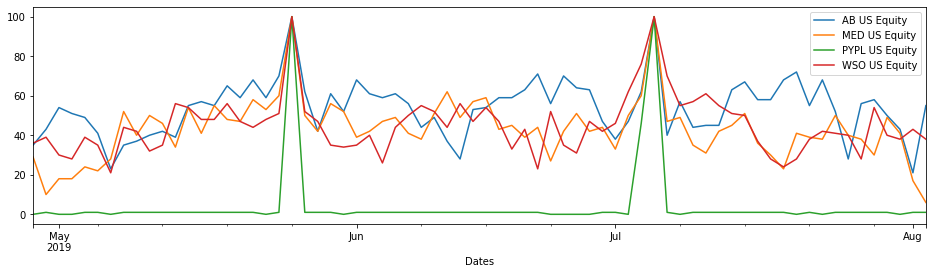

In [22]:
fig, ax = plt.subplots(ncols=1, figsize=(16,4))
nanDF.plot(y=northAMERCompName[0::150]["Stock"],ax=ax)

Two features could be seen here:
1. Huge spikes around end of May and start of July indicating bank holidays in the US.
2. Not sure if thelowe frequency oscillation has any meaning!  
    - This is correlated with the liquidity of the individual stocks.

### 4 Some statistics on the missing datapoints

Now i want to look at how are the missing data distributed amoung the tickers. This might be a criteria we will need to use to select peers. If ticker misses too many data points, I would think that filling the data points might affect the statistics.

More importantly, we 
1. filter the companies by the persentage of the missing data

> getliqcompName(allcoompName, nanSummaryDF, thresh):<br>
This function essentially gets the indeces of companies, whose missing data fullfills a certain percentage, thresh. nanSummaryDF is the overall dataframe for the missing data and allcompName is a data frame of tickernames, which are all saved under "Stock".

In [21]:
def getliqcompName(allcoompName, nanSummaryDF, thresh):
    liqcompList=nanSummaryDF[nanSummaryDF["Mean"]<=thresh].index.values
    liqcomListFinal=np.array([allcoompName[allcoompName["Stock"]==liqcompList[i]].index.values[0] for i in range(len(liqcompList))])
    return liqcomListFinal

In [24]:
northAMERComp10p=getliqcompName(northAMERCompName,nanSummDF,10)

This summaries the number of companies as a function of maximal missing data in pct. 

Text(0, 0.5, 'Number of companies')

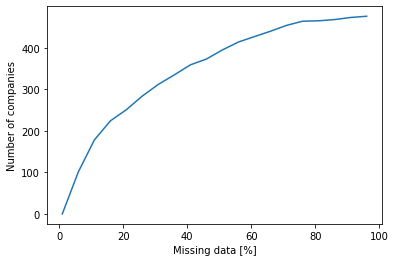

In [27]:
X=range(1,100,5)
Y=[len(getliqcompName(northAMERCompName,nanSummDF,i)) for i in X]
plt.plot(X,Y)
plt.xlabel("Missing data [%]")
plt.ylabel("Number of companies")

# Looking deeper into the data

Now we are aware of what the data are made of. But how should we proceed?<br>
In general, the idea is to creat a basket with the peers. That means a fit. It doesn't matter which kind of fit we do. The number of parameter should not be larger than the dimensions of data space. Otherwise we have too many variables. Even if the number of variables are roughly the same as the number of data points, the fit itself might look good.But the prediciton will be bad. --> see polynomial fitting.<br>
Because of this, let us use the most correlated peers to form a basket. At the first, we need to understand the correltaion more. 

## Trends in pairwise correlation

using sns.pairplot, one build a correlation plot matrix. This means that it looks at the all correlation plots of all variable. It means that the output is a graphicgrid of > $10^4$ plots. Too heavy to plot. I would recommond only plotting partially.

C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


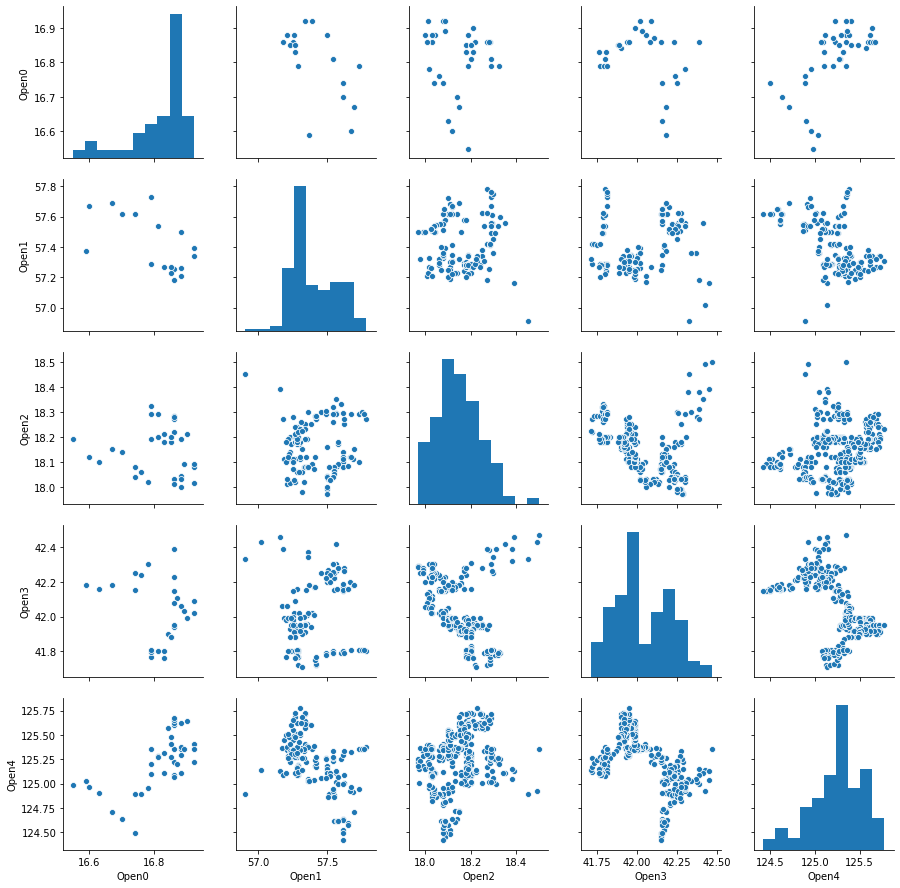

In [15]:
#sns.pairplot(cnEquiDataDay[4].iloc[::,0:15:3])

Let us now generate a DF for daily correlation. As we need to considering data filling. I am interested in the effect of the filling, how much it affects the data statistics.
1. with filling (corrDFRep)
2. without filling (corrDF)

Let us now choose any stock and look at the missing data.

In [25]:
# saves the index of the particular ticker in stNr.
stNr=northAMERCompName[northAMERCompName["Stock"]=="HON US Equity"].index.values[0]
nanSummDF.sort_values(by='Mean', ascending=True).head(1)

,Mean,Std
Stock,,
CNR CN Equity,3.428571,16.699016


In [26]:
# openDataDay and openDataDayRep are list of daily DF without and with filling respectively.
# astype converts the content into float. I dont know why this is required here. But it does the job.
openDataDay=[northAMERdayDF[dayNr].iloc[:,0::3].astype(float) for dayNr in range(len(northAMERdayDF))]
openDataDayRep=[northAMERdayDF[dayNr].iloc[:,0::3].astype(float).fillna(method='ffill').fillna(method='bfill') for dayNr in range(len(northAMERdayDF))]
# Sofar I have only applies forward and backwards filling, there are studies on filling with interpolation. (interpolate(method='spline', order=2))
# However, this requires additional analysis too. For now, I haven't dived into this. 

# Generating DFs for correlation in both cases.
# Ticker names are used as index and columns indicates the number of days.
corrDF =pd.DataFrame()
corrDF["Stock"] = northAMERCompName["Stock"]
corrDFRep =pd.DataFrame()
corrDFRep["Stock"] = northAMERCompName["Stock"]
for dayNr in range(len(northAMERdayDF)):
    # Here I only extract the correlation of the peers with the ticker of interest.
    corrDF[str(dayNr)] =np.array(openDataDay[dayNr].corr()[northAMERCompName.iloc[stNr]["Stock"]+"-Open"])
    corrDFRep[str(dayNr)] =np.array(openDataDayRep[dayNr].corr()[northAMERCompName.iloc[stNr]["Stock"]+"-Open"])
corrDF = corrDF.set_index("Stock")
corrDFRep = corrDFRep.set_index("Stock")
# Ranking in descending order.
corrDF=corrDF.sort_values(by='0', ascending=False)
corrDFRep=corrDFRep.sort_values(by='0', ascending=False)

In [34]:
# Test it
# corrDF.head(3)

Let us compare the correlation with the filling and without, as shown below. For some, the difference is actually quite large. neverthe less, let us proceed with this filling method and see who it contributes to the prediciton. Maybe then, reverse engineer the filling method. 

In [27]:
corrDFtrans=corrDF.transpose()
corrDFReptrans=corrDFRep.transpose()
corrDFtrans.head(2)

Stock,HON US Equity,ITW US Equity,SEED US Equity,RSG US Equity,SLF CN Equity,AGCO US Equity,UBNT US Equity,EMN US Equity,HEI US Equity,PNR US Equity,...,CPB US Equity,BSX US Equity,PTC US Equity,NEP US Equity,NC US Equity,BABY US Equity,CRDE US Equity,HEOL US Equity,SENEB US Equity,SNHY US Equity
0,1.0,0.65405,0.640341,0.636255,0.632045,0.617944,0.607839,0.593071,0.592577,0.591104,...,-0.434905,-0.453420,-0.457718,-0.495269,-0.560755,NaN,NaN,NaN,NaN,NaN
1,1.0,0.85459,0.597397,0.639443,0.776629,0.263777,0.481759,-0.168148,-0.420822,0.601312,...,0.868600,0.148891,-0.624066,0.369392,0.354329,NaN,NaN,NaN,NaN,NaN


### 1. Monthly/Week/Daily correlations
let us now dive deeper and look at the daily, weekly and monthly correlations. To compare them, we need some function to rank/ manipulate the data.

> getRankDF(dataDF, period):<br>
Takes a dataFrame with correlation coefficients as values and tickernames as the indicies. "period" is an option, accepting strings such as  ("M", "ALL", "W", "D"). The function rank the peers by asigning a number 1,2,... This is also the output DF.

> getTop(dataRkDF,topNr):<br>
This takes the tickernames from the ranked DF, which belong to the topX most correlated peers. This returns a DF of Tickernames.

> getavCorr(corrdataDF, period):<br>
This takes the dataframe with the correlation coeff as values. and estimates the averaged correlation over the period, which can be specified by a string, given above.

In [22]:
def getRankDF(dataDF, period):
    rankDF=pd.DataFrame()
    # ranking the correlations
    for i in range(len(dataDF.columns)):
        rankDF[str(i)]=dataDF.iloc[:,i].rank(ascending=False)
    # adjust the output according to the input options
    itemNr=int(len(dataDF.columns))
    if period == "M":
        rankDF.columns= ["Month:"+str(j) for j in range(itemNr)]
    elif period == "ALL":
        rankDF.columns= ["ALL0"]
    elif period == "W":
        rankDF.columns= ["Week:"+str(k) for k in range(itemNr)]
    else:
        rankDF.columns= ["Day:"+str(j) for j in range(itemNr)]
    return rankDF

def getTop(dataRkDF,topNr):
    # get the column of the ranked DF.
    tempDF = dataRkDF
    tempcol=tempDF.columns
    topDF = pd.DataFrame()
    # This goes through all columns in the ranked list. If for some reason the correlation fails, it sets every entry to NaN. 
    # Otherwise, it ranks the peernames by its correlation values and saves it to the output DF.
    for i in range(len(tempcol)):
        if len(tempDF[tempcol[i]][tempDF[tempcol[i]].isna()==False])<1:
            topDF[tempcol[i]]=["NaN" for j in range(topNr)]
        else: 
            testtemp = tempDF[tempDF[tempcol[i]]<=topNr][tempcol[i]].sort_values().index
            if len(testtemp)!=topNr:
                topDF[tempcol[i]]=testtemp.append("NaN")
            else:
                topDF[tempcol[i]]=testtemp
    return topDF

def getavCorr(corrdataDF, period):
    # define the tickers as the index.
    allcorrdf=pd.DataFrame(corrdataDF.index.values, columns=["Stock"])
    dayNr=len(corrdataDF.columns)
    # evaluating the period -option
    if period == "M":
        avPeriod = round(dayNr/22)
        colLabel = "Month:"
        nrcol = 22
    elif period == "ALL":
        avPeriod = 1
        colLabel = "ALL"
        nrcol = dayNr
    elif period == "W":
        avPeriod = round(dayNr/5)
        colLabel = "Week:"
        nrcol = 5
    else:
        avPeriod = dayNr
        colLabel = "Day:"
        nrcol = 1
    # perform averaging on the correlation coefficients.
    for m in range(avPeriod):
        allcorrdf[colLabel+str(m)]=[corrdataDF.transpose().iloc[m*nrcol:m*nrcol+nrcol,i].mean() for i in range(len(corrdataDF))]
    allcorrdf=allcorrdf.set_index("Stock")
    return allcorrdf

To keep notations clear, this is list of data, which we will look at: 
1. avCorr..  : averaged Correlation over all time (3 months)
2. avCorrM.. : averaged Correltiaon per month
3. avCorrW.. : averaged Correltiaon per week
4. avCorrD.. : averaged Correltiaon per day
    
The postfix describes:
1. ..Rank: get rankings
2. ..Top: get the peer names in the Top

In [29]:
avCorr = getavCorr(corrDF,"ALL")
avCorrRank=getRankDF(avCorr, "ALL")

avCorrM = getavCorr(corrDF,"M")
avCorrMRank=getRankDF(avCorrM, "M")

avCorrW = getavCorr(corrDF,"W")
avCorrWRank=getRankDF(avCorrW, "W")

avCorrD = getavCorr(corrDF,"D")
avCorrDRank=getRankDF(avCorrD,"D")

# combine everything together
avCorrSummary=pd.concat([avCorr,avCorrM,avCorrW,avCorrD], axis=1)
avCorrSummary=avCorrSummary.sort_values(by=["ALL0"], ascending=False)

let us look at the overall coefficient-ranking of some of the companies.

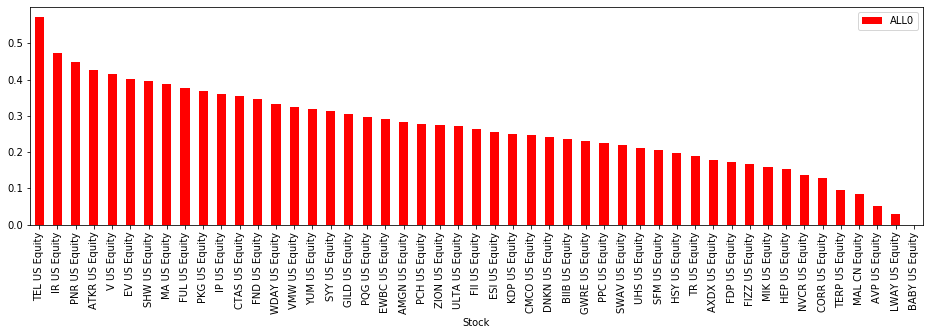

In [49]:
fig, ax = plt.subplots(nrows=1, figsize=(16,4))
avCorrSummary.iloc[1::10].plot.bar(y=["ALL0"],ax=ax, color="r")

Now let us look at how the most overall-most-correlated company vary in their ranking from day to day.

(0, 100)

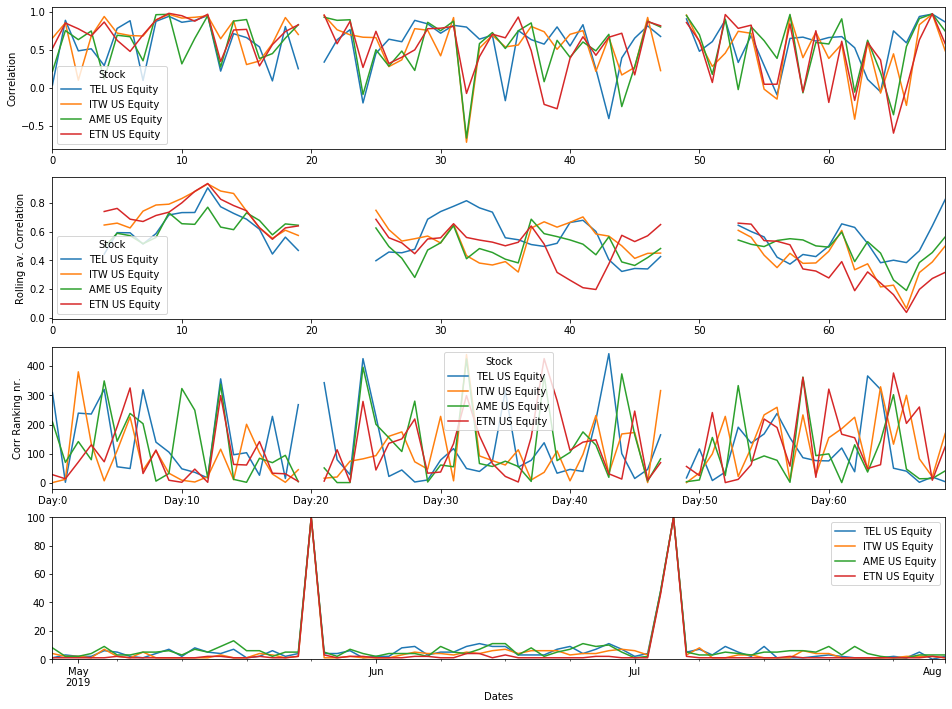

In [58]:
# get a list of overall-most-correlated companies
rankCorrlist=avCorr.sort_values(by=["ALL0"], ascending=False).index.values
fig, ax = plt.subplots(nrows=4, figsize=(16,12))

# Plot the values of the coefficients
corrDFtrans.plot(y=rankCorrlist[1:5],ax=ax[0]).set_ylabel("Correlation")
#corrDFReptrans.plot(y=rankCorrReplist[0:5],ax=ax[0])

# Rolling averaged
corrDFtrans.rolling(window=5).mean().plot(y=rankCorrlist[1:5],ax=ax[1]).set_ylabel("Rolling av. Correlation")
#corrDFReptrans.rolling(window=5).mean().plot(y=rankCorrReplist[0:5],ax=ax[1])

# Plot the ranking number
getRankDF(corrDF,"D").transpose().plot(y=rankCorrlist[1:5],ax=ax[2]).set_ylabel("Corr Ranking nr.")

# Plot the number of the missing files.
nanDF.plot(y=rankCorrlist[1:5],ax=ax[3]).set_ylim(0,100)

It is evident that the correlation is very noise from day to day. There seems to be lower frequnecy in the variation, as shown in the second plot. (Does this mean anything?)<br>
The ranking is for sure very noisy.<br>
Initially, this is believed to be due to missing data. but the last plot shows that it is not dependent on the missing data.

Below, the correlation coefficients are plotted in bar plots for monthly and weekly averaged data. <br>
Red: overall correlation<br>
Other colours: individual weeks/ months.

Also here, it is very visible that correlation change significantly from perid to period.

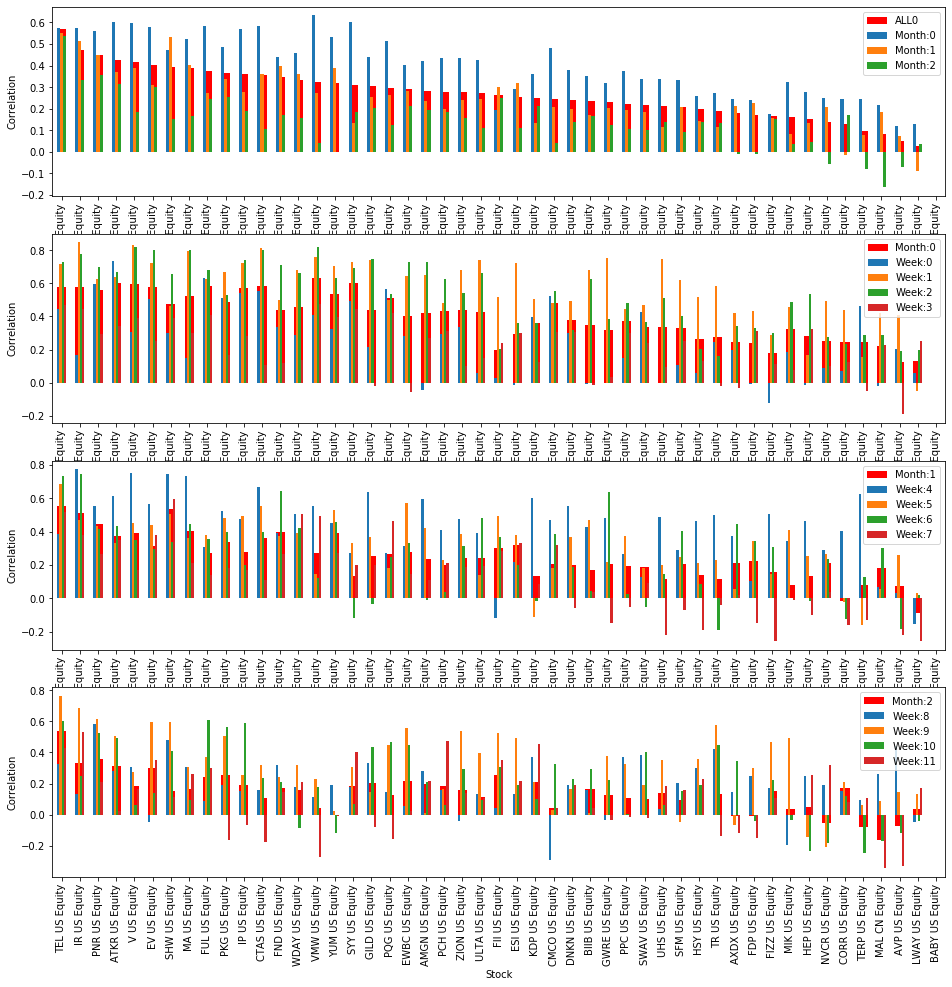

In [60]:
fig, ax = plt.subplots(nrows=4, figsize=(16,16))
avCorrSummary.iloc[1::10].plot.bar(y=["ALL0"],ax=ax[0], color="r").set_ylabel("Correlation")
avCorrSummary.iloc[1::10].plot.bar(y=["Month:"+str(i) for i in range(3)],ax=ax[0])
avCorrSummary.iloc[1::10].plot.bar(y=["Month:0"],ax=ax[1], color="r").set_ylabel("Correlation")
avCorrSummary.iloc[1::10].plot.bar(y=["Week:"+str(i) for i in range(4)],ax=ax[1])
avCorrSummary.iloc[1::10].plot.bar(y=["Month:1"],ax=ax[2], color="r").set_ylabel("Correlation")
avCorrSummary.iloc[1::10].plot.bar(y=["Week:"+str(i+4) for i in range(4)],ax=ax[2])
avCorrSummary.iloc[1::10].plot.bar(y=["Month:2"],ax=ax[3], color="r").set_ylabel("Correlation")
avCorrSummary.iloc[1::10].plot.bar(y=["Week:"+str(i+8) for i in range(4)],ax=ax[3])
#avCorrM.iloc[0:30].plot.bar(ax=ax[1])
#avCorrRep.plot.bar(ax=ax, color="r")

#### 1.1 Noise consideration (Vlad's suggestion)
Sofar we have demonstrated that the fundamental function all work. Before look further, we need to average over longer period of time to filter out the noise.

> corrResamp(dayDataSets, compNamelists, sampRate):<br>
This takes the list of daily dataframe, dayDataSets, and the dataframe of the tickers, compNamelists, as input. The data will be first averaged by "sampRate" ("10T",...) and then correlated. The output is a DF of correlations.

In [23]:
def corrResamp(dayDataSets, compNamelists, sampRate):
    corrResampDF =pd.DataFrame()
    corrResampDF["Stock"] = compNamelists["Stock"]
    for dayNr in range(len(dayDataSets)):
        # averaged dataare correlated and saved as a coloumn in the result-dataframe.
        corrResampDF[str(dayNr)] =np.array(dayDataSets[dayNr].resample(sampRate).mean().corr()[compNamelists.iloc[stNr]["Stock"]+"-Open"])
    corrResampDF = corrResampDF.set_index("Stock")
    corrResampDF=corrResampDF.sort_values(by='0', ascending=False)
    return corrResampDF  

#### 10 min average

In [31]:
corrDF10 = corrResamp(openDataDay, northAMERCompName, "10T")
corrDFtrans10=corrDF10.transpose()
avCorr10 = getavCorr(corrDF10,"ALL")
avCorrRank10=getRankDF(avCorr10, "ALL")

avCorrM10 = getavCorr(corrDF10,"M")
avCorrMRank10=getRankDF(avCorrM10, "M")

avCorrW10 = getavCorr(corrDF10,"W")
avCorrWRank10=getRankDF(avCorrW10, "W")

avCorrD10 = getavCorr(corrDF10,"D")
avCorrDRank10=getRankDF(avCorrD10,"D")


avCorrSummary10=pd.concat([avCorr10,avCorrM10,avCorrW10,avCorrD10], axis=1)
avCorrSummary10=avCorrSummary10.sort_values(by=["ALL0"], ascending=False)
# get top 25 tickers
topNr=25;
avCorrTop10=getTop(avCorrRank10,topNr);
avCorrTopM10=getTop(avCorrMRank10,topNr);
avCorrTopW10=getTop(avCorrWRank10,topNr);
avCorrTopD10=getTop(avCorrDRank10,topNr);
avCorrTopSummary10 = pd.concat([avCorrTop10,avCorrTopM10,avCorrTopW10,avCorrTopD10], axis=1)

#### 60 min average

In [32]:
corrDF60 = corrResamp(openDataDay, northAMERCompName, "60T")
corrDFtrans60=corrDF60.transpose()
avCorr60 = getavCorr(corrDF60,"ALL")
avCorrRank60=getRankDF(avCorr60, "ALL")
avCorrM60 = getavCorr(corrDF60,"M")
avCorrMRank60=getRankDF(avCorrM60, "M")
avCorrW60 = getavCorr(corrDF60,"W")
avCorrWRank60=getRankDF(avCorrW60, "W")
avCorrD60 = getavCorr(corrDF60,"D")
avCorrDRank60=getRankDF(avCorrD60,"D")
avCorrSummary60=pd.concat([avCorr60,avCorrM60,avCorrW60,avCorrD60], axis=1)
avCorrSummary60=avCorrSummary60.sort_values(by=["ALL0"], ascending=False)
topNr=25;
avCorrTop60=getTop(avCorrRank60,topNr);
avCorrTopM60=getTop(avCorrMRank60,topNr);
avCorrTopW60=getTop(avCorrWRank60,topNr);
avCorrTopD60=getTop(avCorrDRank60,topNr);
avCorrTopSummary60 = pd.concat([avCorrTop60,avCorrTopM60,avCorrTopW60,avCorrTopD60], axis=1)

Averaging only slightly changes the order of the most correlated tickers. But the order of the less correlated ticker are changed significantly, which actually makes sense. 

Text(0, 0.5, 'Correlation - 60 min average')

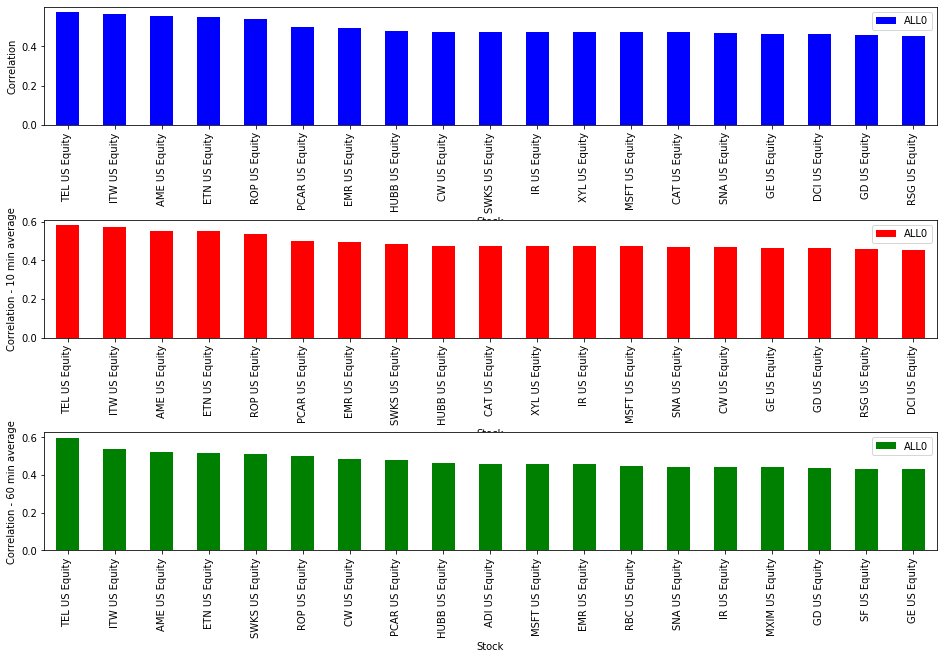

In [67]:
fig, ax = plt.subplots(nrows=3, figsize=(16,10))
fig.subplots_adjust(hspace=.8)
avCorrSummary.iloc[1:20].plot.bar(y=["ALL0"],ax=ax[0], color="b").set_ylabel("Correlation")
avCorrSummary10.iloc[1:20].plot.bar(y=["ALL0"],ax=ax[1], color="r").set_ylabel("Correlation - 10 min average")
avCorrSummary60.iloc[1:20].plot.bar(y=["ALL0"],ax=ax[2], color="g").set_ylabel("Correlation - 60 min average")

Similiarly, the ranking of magnitude remain chaotic.

(0, 100)

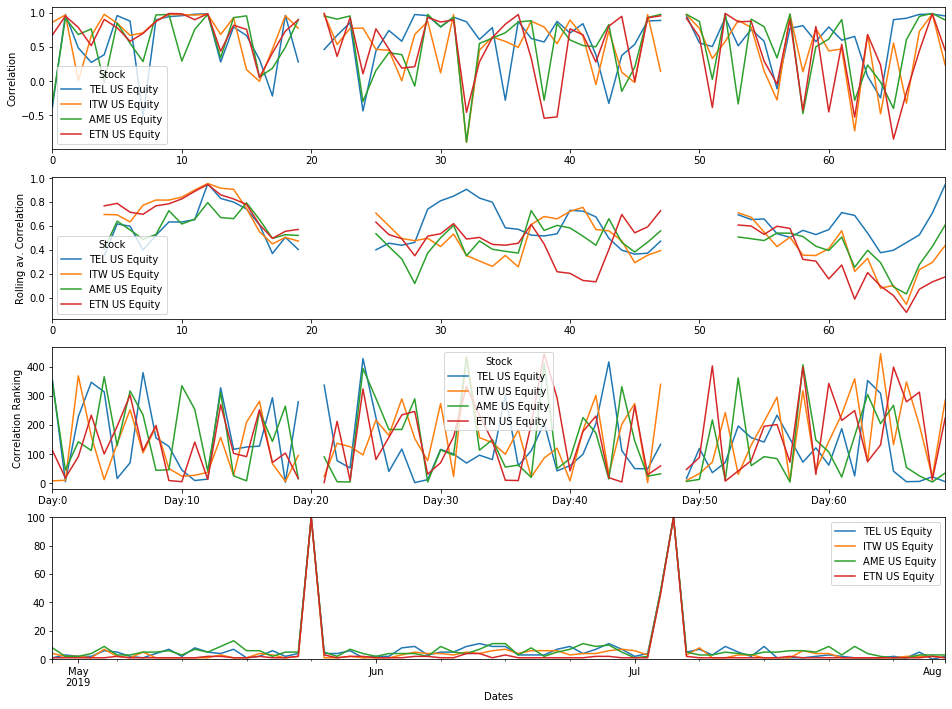

In [71]:
rankCorrlist60=avCorr60.sort_values(by=["ALL0"], ascending=False).index.values
fig, ax = plt.subplots(nrows=4, figsize=(16,12))
corrDFtrans60.plot(y=rankCorrlist60[1:5],ax=ax[0]).set_ylabel("Correlation")
corrDFtrans60.rolling(window=5).mean().plot(y=rankCorrlist60[1:5],ax=ax[1]).set_ylabel("Rolling av. Correlation")
getRankDF(corrDF60,"D").transpose().plot(y=rankCorrlist60[1:5],ax=ax[2]).set_ylabel("Correlation Ranking")
nanDF.plot(y=rankCorrlist60[1:5],ax=ax[3]).set_ylim(0,100)

A list of top 20 tickers using 60 min averaged data.

In [73]:
top20D=pd.DataFrame({"D":avCorrTopSummary60.iloc[:,18::].values.flatten()})["D"].value_counts()[0:25].index
top20W=pd.DataFrame({"W":avCorrTopSummary60.iloc[:,4:18].values.flatten()})["W"].value_counts()[0:25].index
top20M=pd.DataFrame({"M":avCorrTopSummary60.iloc[:,4:18].values.flatten()})["M"].value_counts()[0:25].index
top20ALL=avCorrTopSummary60["ALL0"].iloc[0:25]
top20Samp60=pd.DataFrame([top20ALL,top20M,top20W,top20D]).transpose()
top20Samp60.columns = ["ALL0","Month","Week","Day"]
top20Samp60

,ALL0,Month,Week,Day
0,HON US Equity,HON US Equity,HON US Equity,HON US Equity
1,TEL US Equity,TEL US Equity,TEL US Equity,NaN
2,ITW US Equity,RBC US Equity,RBC US Equity,ROP US Equity
3,AME US Equity,CW US Equity,CW US Equity,AME US Equity
4,ETN US Equity,ROP US Equity,ROP US Equity,ETN US Equity
5,SWKS US Equity,ITW US Equity,ITW US Equity,RBC US Equity
6,ROP US Equity,SWKS US Equity,SWKS US Equity,ITW US Equity
7,CW US Equity,IR US Equity,IR US Equity,FLS US Equity
8,PCAR US Equity,ADSK US Equity,ADSK US Equity,TEL US Equity
9,HUBB US Equity,BRKS US Equity,BRKS US Equity,SHW US Equity


### 2. Trend in the basket peers
For now, I am interested between days and weeks and months. Let us look at how many of the top ranked ticker remain equally top ranked, from day to day, week to week or month to month.

> getIntsecComp0(dataDF): <br>
It compares the neibouring items in a list for common items and saves only the common items after each comparison in a separated list as output.

> getIntsecComp(dataDF, transNr): <br>
This converts the dataframe with company names into lists and compares the individual sublists, which are separated by transNr. (If transNr =1, neoughring list. = 2 --> comparing every third list....)

>getCorrTopTrend(dataDF):<br>
Here, i look at the number of tickers occuring in two lists with top correlated companies. This function compares the subsequent days and build a mean and stdDev. Then it compares every third, fourth,.. list with each other. The output is a dataframe with number of transition of list as index. and Mean + stdDev of the survivinig companies as content.

In [24]:
def getIntsecComp(dataDF, transNr):
    # convert DF into list
    intlist=dataDF.transpose().values.tolist()    
    for nr in range(transNr):
        complist0 = getIntsecComp0(intlist)
        intlist=complist0
    return intlist


def getIntsecComp0(datalist):
    intlist=[]
    for i in range(len(datalist)-1):
        # compare lists
        intlist0=list(set(datalist[i])&set(datalist[i+1]))
        intlist.append(intlist0)
    return intlist

def getCorrTopTrend(dataDF):
    df=pd.DataFrame()
    # dataDF is a DF, where every column shows the most correlation peers of every day/ week/ ... 
    # get number of days
    totalLen = len(dataDF.transpose())
    lenlist=[]
    lenerrlist=[]
    # scan through the number of days
    for t in range(1,totalLen):
        temp = [x for x in getIntsecComp(dataDF,t) if x != []]
        # getting the average and standdeviation
        lenlist0 = np.mean([len(i) for i in temp])
        lenerrlist0 = np.std([len(i) for i in temp])
        lenlist.append(lenlist0)
        lenerrlist.append(lenerrlist0)
    df["MeanNr Comp"]=lenlist
    df["Err"]=lenerrlist
    df["NrTrans"] =range(1,totalLen)
    df=df.set_index("NrTrans")
    return df

In [34]:
# get top correlated company names for monthly/ weekly and daily data.
topNr=25;
avCorrTop=getTop(avCorrRank,topNr);
avCorrTopM=getTop(avCorrMRank,topNr);
avCorrTopW=getTop(avCorrWRank,topNr);
avCorrTopD=getTop(avCorrDRank,topNr);
avCorrTopSummary = pd.concat([avCorrTop,avCorrTopM,avCorrTopW,avCorrTopD], axis=1)

# Apply averaging on the raw data (10 or 60 min)
avCorrTopminW=avCorrTopSummary.iloc[:,4:18]
avCorrTopminD=avCorrTopSummary.iloc[:,18::]
avCorrTop10minW=avCorrTopSummary10.iloc[:,4:18]
avCorrTop10minD=avCorrTopSummary10.iloc[:,18::]
avCorrTop60minW=avCorrTopSummary60.iloc[:,4:18]
avCorrTop60minD=avCorrTopSummary60.iloc[:,18::]

# find the number of curvivals
corrT25TrendminW=getCorrTopTrend(avCorrTopminW)
corrT25TrendminD=getCorrTopTrend(avCorrTopminD)
corrT25Trend10minW=getCorrTopTrend(avCorrTop10minW)
corrT25Trend10minD=getCorrTopTrend(avCorrTop10minD)
corrT25Trend60minW=getCorrTopTrend(avCorrTop60minW)
corrT25Trend60minD=getCorrTopTrend(avCorrTop60minD)

C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(1, 5)

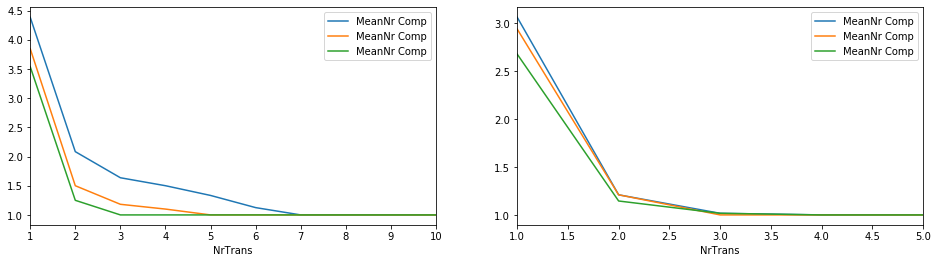

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
corrT25TrendminW.plot(y=["MeanNr Comp"],ax=ax[0]).set_xlim(1,10)
corrT25Trend10minW.plot(y=["MeanNr Comp"],ax=ax[0]).set_xlim(1,10)
corrT25Trend60minW.plot(y=["MeanNr Comp"],ax=ax[0]).set_xlim(1,10)
corrT25TrendminD.plot(y=["MeanNr Comp"],ax=ax[1]).set_xlim(1,5)
corrT25Trend10minD.plot(y=["MeanNr Comp"],ax=ax[1]).set_xlim(1,5)
corrT25Trend60minD.plot(y=["MeanNr Comp"],ax=ax[1]).set_xlim(1,5)

This is scary!!<br>
LEFT:<br>
This shows the mean number of common equities as a function of the numnber of past weeks.<br>
RIGHT:<br>
This shows the mean number of common equities as a function of the numnber of past days.


let us be more clear about this and illustrate it as a function time.

> commEqvsTime(corrDataDFlist, nrTrans): <br>
This combines literatlly the results using different averaging into one signle dataframe. Easier to compare!<br>
Here corrDataDFlist is a list of list and one can specify the nr of days of interests. 

In [25]:
def commEqvsTime(corrDataDFlist, nrTrans):
    testdf=pd.DataFrame({
        "60 min":[x for x in [len(i) for i in getIntsecComp(corrDataDFlist[2],nrTrans)] if x!=0],
        "10 min":[x for x in [len(i) for i in getIntsecComp(corrDataDFlist[1],nrTrans)] if x!=0],
        "1 min":[x for x in [len(i) for i in getIntsecComp(corrDataDFlist[0],nrTrans)] if x!=0]
        })
    return testdf

In [37]:
dayCommon2=commEqvsTime([avCorrTopminD,avCorrTop10minD,avCorrTop60minD],1)
dayCommon3=commEqvsTime([avCorrTopminD,avCorrTop10minD,avCorrTop60minD],2)
weekCommon2=commEqvsTime([avCorrTopminW,avCorrTop10minW,avCorrTop60minW],1)
weekCommon3=commEqvsTime([avCorrTopminW,avCorrTop10minW,avCorrTop60minW],2)

More into detail.

In the following graphs: the left graphs show the number of ticker compared with neighboring lists for daily data, whereas the right hand sides show the weekly data.

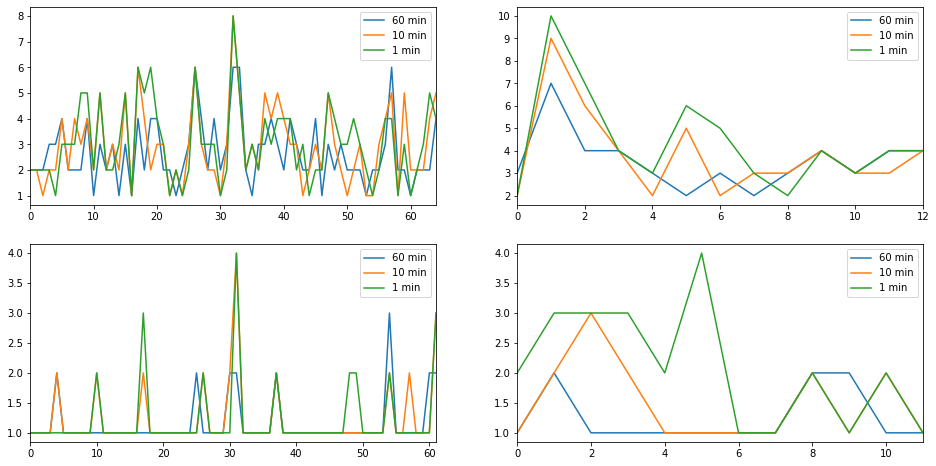

In [101]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(16,8))
dayCommon2.plot(ax=ax[0][0])
weekCommon2.plot(ax=ax[0][1])
dayCommon3.plot(ax=ax[1][0])
weekCommon3.plot(ax=ax[1][1])

In comparison with the price data, shown below, sadly there is no clear correlations.

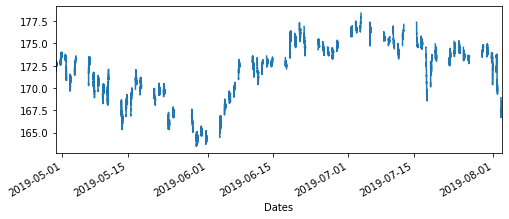

In [265]:
fig, ax = plt.subplots(ncols=1, figsize=(8,3))
pd.concat([openDataDay[i]["HON US Equity-Open"] for i in range(70)]).plot(ax=ax)

I have repeated the above analysis for other equities. All of them suggests that the list of most correlated companies are not stable. If we choose to use longer histric data, we might missout quite lot short term market activity, because its contribution to the larger amount of the data is just insignifiant. This is solely my intuition. Maybe one should back this up with some simulations. --> This will require quite a lot data and computing power.

Anyway, let us for now, accept the fact that the peer list will change contineously and move-on to the predicciton part and see if it actually delivers something sensible.

# Using regression to reproduce the share price

When using regression to predict the price of a particular stocks using its OPEN/HIGH/... data, it has been proven to be less effective. This is due to the fact that the parameters are all highly correlated.<br>
However, this doesn't apply to us, as the peer prices are less correlated.

My first impression for using dimensional reduction is that it is not nessesary useful, as we have more data than the parameters. Unless we only use previous days data, then we will run into problems. 

Anyway, let us start with ordinary regression and compare the results with the correlations. If there is a trend, we can accelerate the progress of chossing peers!!

Standardising forces the mean to zero. Here, one focuses on the change, such as volatitity.

For us, we are interested in the trend. Hence we need the full scale/ or relative scale --> Normalisation.)

In [26]:
import statsmodels.api as sm
from sklearn import preprocessing

Lets try put all data into one single dataframe.

In [27]:
# here I onlt take the Open price
openDataDayRep=[
    northAMERdayDF[dayNr].iloc[:,0::3].astype(float) 
    for dayNr in range(len(northAMERdayDF))]
# again forward and backward filling and erasing empty columns
weekData = pd.concat([openDataDayRep[i] for i in range(70)]).fillna(method='ffill').fillna(method='bfill').dropna(axis=1, how='all')

I am not sure if I gonna need it. It is  good to have it.

In [28]:
# This essentially normalises every single column in the dataDF against its MAX-MIN.
def normal(dataDF):
    collist = dataDF.columns
    newdataDF=pd.DataFrame()
    for i in collist:
        newdataDF[i] = (dataDF[i]-min(dataDF[i]))/(max(dataDF[i])-min(dataDF[i]))
    newdataDF = newdataDF.set_index(dataDF.index)
    return newdataDF

## 1 Uniform weighting (OLS)

Let us start with uniformly weighted regression - no particular preferences  
Now let us look at:
1. Coeff as a function of time
2. Residual of prediction as a function of duration of data used
3. MSE of prediction as a function of duration of data into the future
4. MSE of prediction as a function of length of training data (start with twice as much parameters)


In [29]:
# separates the data into trainign and validation data. The output is a list of variables (X) and target (Y).
def prepTrainData(data, nrTrain, stockname):
    train = data[:nrTrain]
    Xtrain = train.drop(stockname, axis=1)
    Ytrain = pd.DataFrame()
    Ytrain["Data"]=train[stockname]
    return [Xtrain, Ytrain]

# similiar to above, just for validation set
def prepValidData(data, nrTrain, stockname):
    valid = data[nrTrain:]
    Xvalid = valid.drop(stockname, axis=1)
    Yvalid = pd.DataFrame()
    Yvalid["Data"]=valid[stockname]
    return [Xvalid, Yvalid]

# Get the fit function OLS 
def getTrainFit(data, nrTrain, stockname):
    train = prepTrainData(data, nrTrain, stockname)
    # adding a constant
    Xtrain = sm.add_constant(train[0])
    Ytrain = sm.add_constant(train[1])
    #w = [1/np.sqrt(len(Xtrain)-i)**2 for i in range(len(Xtrain))]
    est = sm.WLS(Ytrain["Data"], Xtrain)
    est2 = est.fit()
    return est2

# to look at the R squared
def getRSq(data, nrTrain, stockname):
    fitfct=getTrainFit(data, nrTrain, stockname)
    return fitfct.rsquared


# creating a dataframe for the fit coefficients
def getCoefDF(data, nrTrain, stockname):
    Xtrain = prepTrainData(data, nrTrain, stockname)[0]
    fitfct = getTrainFit(data, nrTrain, stockname)
    coefDF = pd.DataFrame(index = Xtrain.columns)
    coefDF["Coef"] = fitfct.params
    coefDF["StdErr"] = fitfct.bse
    coefDF["p-value"] = fitfct.pvalues
    return coefDF

def getTrainFitData(data, nrTrain, stockname):
    Ytrain = prepTrainData(data, nrTrain, stockname)[1]
    Xtrain = prepTrainData(data, nrTrain, stockname)[0]
    fitfct=getTrainFit(data, nrTrain, stockname)
    Xtrain = sm.add_constant(Xtrain)
    Ytrain["Fit"] = fitfct.predict(Xtrain)
    Ytrain["Res"] = Ytrain["Data"]-Ytrain["Fit"]
    return Ytrain

# get the results on validation or prediction
def getValidDF(data, nrTrain, stockname):
    validdata=prepValidData(data, nrTrain, stockname)
    Xvalid = validdata[0]
    #Yvalid = pd.DataFrame()
    Yvalid=validdata[1]
    fitfct = getTrainFit(data, nrTrain, stockname)
    Yvalid["Pred"] = fitfct.predict(Xvalid)
    Yvalid["Res"] = Yvalid["Data"]-Yvalid["Pred"]
    Yvalid["MSE"] = Yvalid["Res"]**2
    return Yvalid

### 1.1.1 RSq vsTime
Let us see, how the fit quality looks like over time.

In [120]:
RSQvsHour = [getRSq(weekData[i:1000+i], 800, "MSFT US Equity-Open") for i in range(0, len(weekData)-1000, 60)]

In [121]:
np.mean(RSQvsHour), np.std(RSQvsHour)

(0.9994067724070065, 0.0006192387744049143)

Text(0, 0.5, 'R^2')

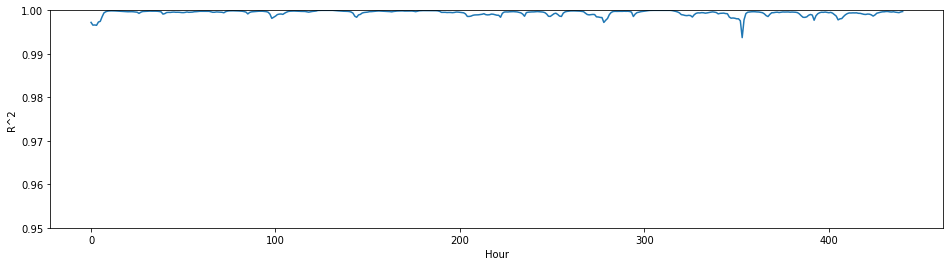

In [122]:
fig, ax = plt.subplots(ncols=1, figsize=(16,4))
ax.plot(RSQvsHour)
ax.set_ylim([0.95,1])
plt.xlabel("Hour")
plt.ylabel("R^2")

$R^2$ looks very good.

### 1.1.2 Coefficients vs time
Coefficient distribition in the first 1000 min. I look at how the OLS obtained top-25 coefficient changes as we increase the number of data, by adding minutes into the traingin set.

In [30]:
# looks at the number of common peers obtained from OLS by looking at 2000 data point and 2000+x minutes
def getPeerNr(data, nrTrain, stockname, topNr,survMin):
    meanNr=np.mean([
        len(getCoefDF(data[0+i:2000+i], nrTrain, stockname).sort_values(by=["Coef"],ascending=False).index[:topNr] & getCoefDF(weekData[survMin+i:2000+survMin+i], nrTrain, stockname).sort_values(by=["Coef"],ascending=False).index[:topNr])
        for i in range(0,len(data),2000)])
    return meanNr

In [ ]:
survNr=[getPeerNr(weekData, 800, "MIDD US Equity-Open", 25,i) for i in range(10,200,10)];

In [ ]:
survNr2000=[getPeerNr(weekData, 1800, "MIDD US Equity-Open", 25,i) for i in range(10,200,10)];

This is even more scary. Every minute we added to the training, the companies, which initially contributed the most to the analysis of the first 1000 minuts, start to change. This shows that the system is highly dynamic.

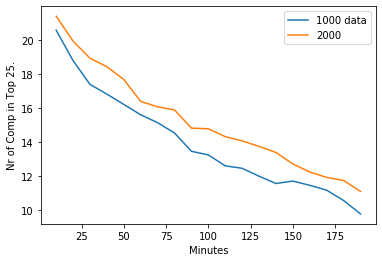

In [821]:
plt.plot(range(10,200,10), survNr, label= "1000 data")
plt.plot(range(10,200,10), survNr2000)
plt.xlabel("Minutes")
plt.ylabel("Nr of Comp in Top 25.")
plt.legend(["1000 data","2000"])
plt.show()

### 1.1.3 Prediction Residuals
Here i want to have the following measure:
1. Residuals vs prediction duration
2. Residuals vs training data length

There are essentially two loops: one for mapping through the past history data and estimate the mean. The other for increasing the length of the data to be predicted.

In [43]:
meanRes1000=[np.mean([getValidDF(weekData[0+i:1000+i], 800, "MRU CN Equity-Open")["Res"][:predMin].std()/getValidDF(weekData[0+i:1000+i], 800, "MRU CN Equity-Open")["Data"][0] for i in range(0, len(weekData)-1000,1000)]) for predMin in range(20,200,20)]
stdRes1000=[np.std([getValidDF(weekData[0+i:1000+i], 800, "MRU CN Equity-Open")["Res"][:predMin].std()/getValidDF(weekData[0+i:1000+i], 800, "MRU CN Equity-Open")["Data"][0] for i in range(0, len(weekData)-1000,1000)]) for predMin in range(20,200,20)]

C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


This is makes sense. The futher into future we look, the higher is the uncertainty.

Text(0, 0.5, 'Absolute value')

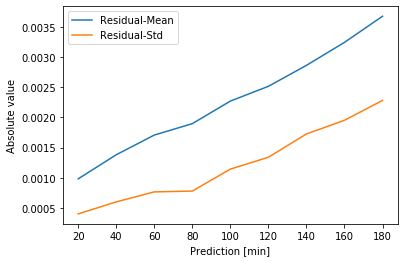

In [44]:
plt.plot(range(20,200,20), meanRes1000)
plt.plot(range(20,200,20), stdRes1000)
plt.legend(["Residual-Mean","Residual-Std"])
plt.xlabel("Prediction [min]")
plt.ylabel("Absolute value")

In [155]:
meanResvsnrTrain=[np.mean([getValidDF(weekData[0+i:5000+i], nrTrain, "MIDD US Equity-Open")["Res"][:100].std()/getValidDF(weekData[0+i:5000+i], nrTrain, "MIDD US Equity-Open")["Data"][0] for i in range(0, len(weekData)-5000,5000)]) for nrTrain in range(400,4800,400)]
stdResvsnrTrain=[np.std([getValidDF(weekData[0+i:5000+i], nrTrain, "MIDD US Equity-Open")["Res"][:100].std()/getValidDF(weekData[0+i:5000+i], nrTrain, "MIDD US Equity-Open")["Data"][0] for i in range(0, len(weekData)-5000,5000)]) for nrTrain in range(400,4800,400)]

Now let us sit at 100 min and look at the error as a function of length of the training data.<br>
Interestingly there is exponential decay. --> not sure yet how this will be useful. --> still interesting.

Text(0, 0.5, 'Rel residuals @ 100 min')

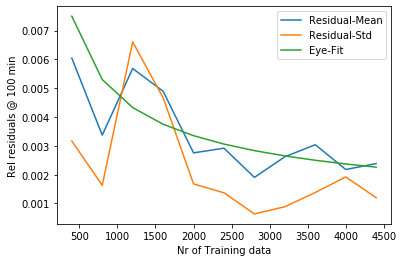

In [156]:
plt.plot(range(400,4800,400), meanResvsnrTrain)
plt.plot(range(400,4800,400), stdResvsnrTrain)
plt.plot(range(400,4800,400), 0.15/(np.arange(400,4800,400))**(1/2))
plt.legend(["Residual-Mean","Residual-Std", "Eye-Fit"])
plt.xlabel("Nr of Training data")
plt.ylabel("Rel residuals @ 100 min")

### 1.1.4. MSE 
Similiarly, I looked at the MSE and as, expected, the more data we use, to less the error. Prediction fixed at 200 min.

In [85]:
test=[np.mean([getValidDF(weekData[0+i:6000+i], nrTrain, "BG US Equity-Open")["MSE"][:200].mean() for i in range(0, len(weekData)-6000,6000)]) for nrTrain in range(400,5800,400)]

C:\Users\x.cheng\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Text(0, 0.5, 'Rel. MSE')

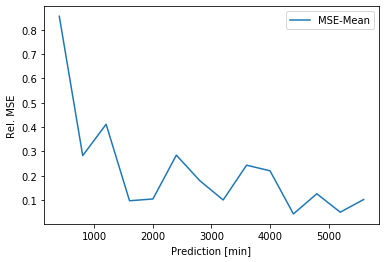

In [86]:
plt.plot(range(400,5800,400), test)
#plt.plot(range(20,200,20), stdRes5000)
plt.legend(["MSE-Mean"])
plt.xlabel("Prediction [min]")
plt.ylabel("Rel. MSE")

Eventually, it starts to increase!!!

In [80]:
test=[getValidDF(weekData[0+i:2500+i], 2200, "MSFT US Equity-Open")["MSE"][:200].mean() for i in range(0, len(weekData)-2500,2000)]

Text(0, 0.5, 'MSE')

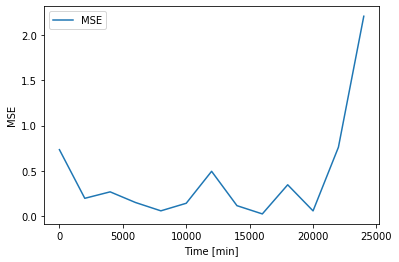

In [81]:
plt.plot(range(0, len(weekData)-2500,2000), test)
#plt.plot(range(20,200,20), stdRes5000)
plt.legend(["MSE"])
plt.xlabel("Time [min]")
plt.ylabel("MSE")

## 2. Lasso

Due to variabes (equities), which are correlated, there is a danger of double-counting equities. Lasso has these tendency to surpress the coefficients to zero. The advantage lies in interpretating the outcome.

The disadvantage is that there is no input of weight yet, This requires more investigation. After some googling, there seems to be other ppl having the same issue. So there must be a solution to that. Because of this, lets worry about this later.

Another important point I want to mention is to use RETURNS rather than the real price. If we use RETURN, the problem seems to vanish. Return works with relative increase of stock price. Hence I convert the trainign set into return values before training. The data will start off somewhere around 0 and increase or decrease. But the parameter space will be always somewhere close to 0. I do the same to convert the validation data for the peers. This brings the first few data points of the validation sets to 0 again. In this case, we have offset the validation data to be within the range of the model. However, without proof, it feels like that we are overvaluing the data around 0 rather elsewhere. because of this, it might be worth considering using another method where the most recent data are valued. But this is for the future, let us see, what we can get with this.

> getLassoFit(data, nrTrain, stockname, alph):<br>
takes the raw data as input and gives out the optimised function of Lasso. This doesnt have any values yet. Futher options are required.<br>
Key things to highlight: normalisation on the data is important to get a good calibration on contribution of the peers. Otherwise, the contribution might not have much meaning. tol defines the calculation precision, it defines the time consumption of the simulation. max_iter sets a limit on non-converging solutions.

> getLassoRSq(data, nrTrain, stockname, alph):<br>
this gives out the RSquared value of the fit. It is high recommonded to restructure the code here. Too many duplications.

The following are some of the key functions used across the my notebooks.

> getLassoTrainDF(data, nrTrain, stockname, alph): <br>
It essentially splits and converts the training and validation sets into Returns. Estimates the fit function and creates a dataframe of Real train data, basket data, vsBasket data, MSE. The time stamps of the training is set as the index. 

> getLassoValidDF(data, nrTrain, stockname, alph):<br>
This is done literally the same as getLassoTrainDF, just the prediciton is on the validation set.

> getLassoCoefNr(data, nrTrain, stockname, alph):<br>
gives out the number of peers used in the training.

In [31]:
from math import log
# converting to RETURNS for the training set
def getReturnTrain(data, nrTrain, stockname):
    raw = prepTrainData(data, nrTrain, stockname)
    for j in range(2):
        rawcol= raw[j].columns
        for i in rawcol:
            raw[j][i] = (raw[j][i]-raw[j][i][0])*10000/raw[j][i][0]
    return raw

# converting to RETURNS for the validation set
def getReturnValid(data, nrTrain, stockname):
    raw = prepValidData(data, nrTrain, stockname)
    for j in range(2):
        rawcol= raw[j].columns
        for i in rawcol:
            raw[j][i] = (raw[j][i]-raw[j][i][0])*10000/raw[j][i][0]
    return raw

def getLassoFit(data, nrTrain, stockname, alph):
    train = getReturnTrain(data, nrTrain, stockname)
    lml = linear_model.Lasso(alpha=alph, normalize=True,tol=0.00001, max_iter=500)
    est2=lml.fit(train[0],train[1])
    return est2
############################################
###### First attempt to simplify
# def getLassoFit0(returnTraindata, alph):
#    lml = linear_model.Lasso(alpha=alph, normalize=True,tol=0.00001, max_iter=500)
#    est2=lml.fit(returnTraindata[0],returnTraindata[1])
#    return est2
############################################
def getLassoRSq(data, nrTrain, stockname, alph):
    train = getReturnTrain(data, nrTrain, stockname)
    lml = linear_model.Lasso(alpha=alph, normalize=True)
    return lml.score(train[0],train[1])
############################################
# def getLassoRSq0(returnTraindata, alph):
#     lml = linear_model.Lasso(alpha=alph, normalize=True)
#     return lml.score(returnTraindata[0],returnTraindata[1])
############################################
def getLassoTrainDF(data, nrTrain, stockname, alph):
    traindata=getReturnTrain(data, nrTrain, stockname)
    Xtrain = traindata[0]
    #Yvalid = pd.DataFrame()
    Ytrain=traindata[1]
    fitfct = getLassoFit(data, nrTrain, stockname, alph)
    Ytrain["Basket"] = fitfct.predict(Xtrain)
    Ytrain["vsBasket"] = Ytrain["Data"]-Ytrain["Basket"]
    Ytrain["MSE"] = Ytrain["vsBasket"]**2
    return Ytrain
############################################
def getLassoTrainDF0(data, nrTrain, stockname, alph):
    traindata=getReturnTrain(data, nrTrain, stockname)
    Xtrain = traindata[0]
    #Yvalid = pd.DataFrame()
    Ytrain=traindata[1]
    fitfct = getLassoFit0(traindata, alph)
    Ytrain["Basket"] = fitfct.predict(Xtrain)
    Ytrain["vsBasket"] = Ytrain["Data"]-Ytrain["Basket"]
    Ytrain["MSE"] = Ytrain["vsBasket"]**2
    return Ytrain


############################################
def getLassoValidDF(data, nrTrain, stockname, alph):
    validdata=getReturnValid(data, nrTrain, stockname)
    Xvalid = validdata[0]
    #Yvalid = pd.DataFrame()
    Yvalid=validdata[1]
    fitfct = getLassoFit(data, nrTrain, stockname, alph)
    Yvalid["Basket"] = fitfct.predict(Xvalid)-fitfct.predict(Xvalid)[0]
    Yvalid["vsBasket"] = Yvalid["Data"]-Yvalid["Basket"]
    Yvalid["MSE"] = Yvalid["vsBasket"]
    return Yvalid
############################################
# def getLassoValidDF0(data, nrTrain, stockname, alph):
#    validdata=getReturnValid(data, nrTrain, stockname)
#    traindata=getReturnTrain(data, nrTrain, stockname)
#    Xvalid = validdata[0]
#    #Yvalid = pd.DataFrame()
#    Yvalid=validdata[1]
#    fitfct = getLassoFit0(traindata, alph)
#    Yvalid["Basket"] = fitfct.predict(Xvalid)-fitfct.predict(Xvalid)[0]
#    Yvalid["vsBasket"] = Yvalid["Data"]-Yvalid["Basket"]
#    Yvalid["MSE"] = Yvalid["vsBasket"]
#    return Yvalid

def getLassoCoefNr(data, nrTrain, stockname, alph):
    fitfct = getLassoFit(data, nrTrain, stockname, alph)
    coeff=fitfct.coef_
    return len(coeff[coeff!=0])

#def getLassoCoefNr0(data, nrTrain, stockname, alph):
#    traindata=getReturnTrain(data, nrTrain, stockname)
#    fitfct = getLassoFit0(traindata, alph)
#    coeff=fitfct.coef_
#    return len(coeff[coeff!=0])

######################################################################


The function below is to estimate the number of peers used in the model for a given $\alpha$ and output the $\alpha$ with lowest MSE.
> getMinAlpha(powlist, data, nrTrain, stockname):<br>
it takes a list of $\alpha$ in the unit of exponent ($10^x$) and delivers the mean MSE over 200 predicted data. At the same time, it calculates the number of company used for that particular setting. Everything are then saved as a dataframe. As the output, it picks out the one with the lowest MSE. IT can be changed to diliver the whole list.

In [32]:
def getMinAlpha(powlist, data, nrTrain, stockname):
    df=pd.DataFrame()
    # set the alpha as a list.
    df["AlphaPow"] = powlist
    # get the mean MSE
    mselist=[getLassoValidDF(data, nrTrain, stockname,10**power)["MSE"][:200].mean() for power in powlist]
    # get the number of the companies
    nrcomplist = [getLassoCoefNr(data, nrTrain, stockname,10**power) for power in powlist]
    df["MSE"] = mselist
    df["nrCompany"] = nrcomplist
    df=df.set_index("AlphaPow")
    # this is just arbitrary.
    df=df[df["nrCompany"]>3]
    # only return the value with lowest the MSE
    return df[df["MSE"]==min(df["MSE"])].index[0]

NOOW, we have everything which we can potentially think of to do some analysis. But at the first let us look at the data.

### Plotting section
Let us look at the training and validation sets. Lets also do a pretty plotting definition.

In [33]:
def plotVsBasket(lassoResDF):
    x=lassoResDF.index
    y=lassoResDF["vsBasket"]
    plt.fill_between(x,y, where=y>=0,color="g",alpha=0.5)
    plt.fill_between(x,y, where=y<=0,color="r",alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Return [bps]")

We have loaded the last 3 month data that corresponds to over 65 days of data. I have introduced the following parameters to select a particular day of interest.<br>
1. offset: number of the days of offset before starting looking at the training data.
2. nr: number of days to be used in the training data
3. alpha: the lasso parameter
4. comp: is the company ticker

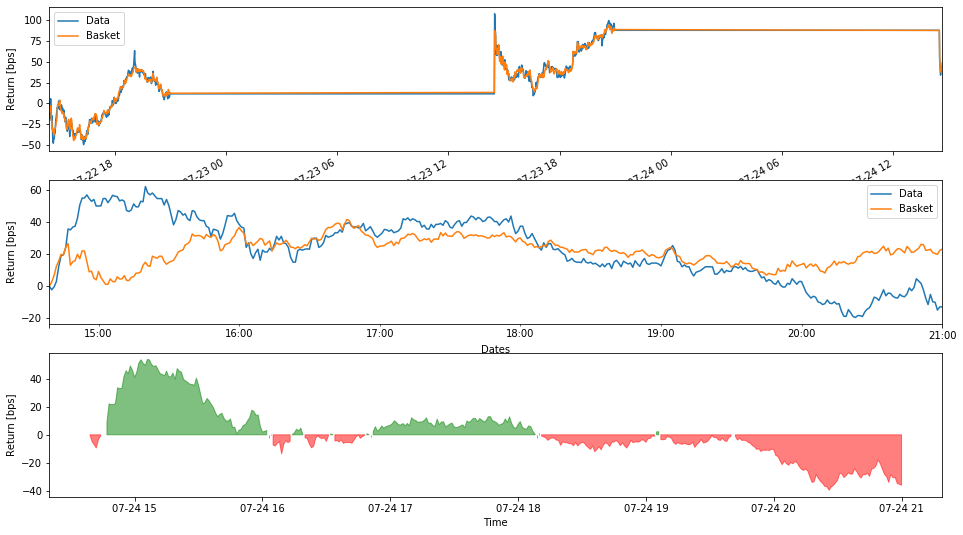

In [34]:
offset=60
nr=2
alpha= 0.01
comp = "HON US Equity-Open"
# get training and validation outcome
lassoTrain=getLassoTrainDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+10, comp,alpha)
lassoValid=getLassoValidDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+10, comp,alpha)
# plot them
fig, ax = plt.subplots(nrows=3, figsize=(16,10))
lassoTrain.plot(y=["Data","Basket"], ax=ax[0]).set_ylabel("Return [bps]")
lassoValid.plot(y=["Data","Basket"], ax=ax[1]).set_ylabel("Return [bps]")
ax[2]= plotVsBasket(lassoValid)

### Optimising Lasso $\alpha$
Now we have the ploting features. So lets look at the $\alpha$-optimisation by MSE.<br>
Here, a for-loop scans through the days and creates a list of the summed MSE as a function of $\alpha$.

In [37]:
nr=5
avgList=[]
for power in np.arange(-3,0,0.5):
    alpha=10**(power)
    #lassoTrain=getLassoTrainDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+30, "HON US Equity-Open",alpha)
    resSum=[getLassoValidDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+30, "HON US Equity-Open",alpha)["MSE"].mean() for offset in range(62)]
    avgList.append(np.abs(resSum))

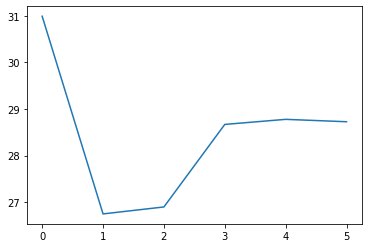

In [45]:
plt.plot([i.mean() for i in avgList])

Using the same procedure, we can optimise the length of min to be included in the trainig set.

In [ ]:
nr=20
intraMinList=[]
for mindelay in np.arange(0,60,10):
#lassoTrain=getLassoTrainDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+30, "HON US Equity-Open",alpha)
    intraMin=[getLassoValidDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+mindelay, "HON US Equity-Open",10**(-2.3))["MSE"].sum() for offset in range(45)]
    intraMinList.append(np.abs(intraMin))

### Training with daily data
Here I have only used one days data to predict next days data. I have turned everything into return values to optimise the fitting due to the range of the variables. As prediciton often has an offset, causing the difficulties to explain the returns in the future. I substract all predictions form the first value. 

The idea is to achieve the highest mean reversion. hence, i optimise here the sum of the residuals, rather than MSE.<br>
For some reason, I have lost the resSumList.<br>

HENCE, DO NOT EXCECUT the following. They are for illustrations.

Text(0, 0.5, 'sum(res)')

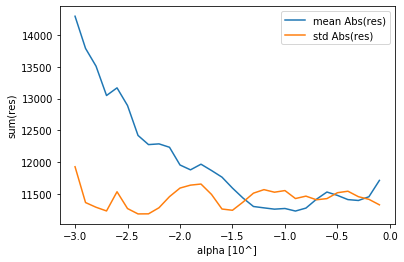

In [985]:
plt.plot(np.arange(-3,0,0.1),[resSumList[i].mean() for i in range(len(resSumList))],label="mean alpha")
plt.plot(np.arange(-3,0,0.1),[resSumList[i].std() for i in range(len(resSumList))])
plt.legend(["mean Abs(res)","std Abs(res)"])
plt.xlabel("alpha [10^]")
plt.ylabel("sum(res)")

Looking at the dependence of time to be included in the training set.

Text(0, 0.5, 'sum(res)')

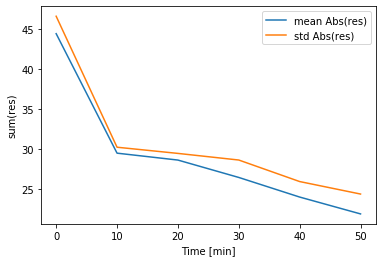

In [1074]:
plt.plot(np.arange(0,60,10),[intraMinList[i].mean()/(392-np.arange(0,60,10)[i]) for i in range(len(intraMinList))])
plt.plot(np.arange(0,60,10),[intraMinList[i].std()/(392-np.arange(0,60,10)[i]) for i in range(len(intraMinList))])
plt.legend(["mean Abs(res)","std Abs(res)"])
plt.xlabel("Time [min]")
plt.ylabel("mean(res)")

### Training with weekly data

Text(0, 0.5, 'sum(res)')

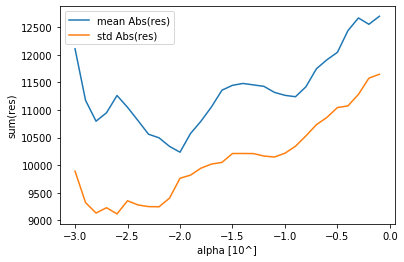

In [987]:
plt.plot(np.arange(-3,0,0.1),[resSumList5[i].mean() for i in range(len(resSumList5))],label="mean alpha")
plt.plot(np.arange(-3,0,0.1),[resSumList5[i].std() for i in range(len(resSumList5))])
plt.legend(["mean Abs(res)","std Abs(res)"])
plt.xlabel("alpha [10^]")
plt.ylabel("sum(res)")

Text(0, 0.5, 'mean(res)')

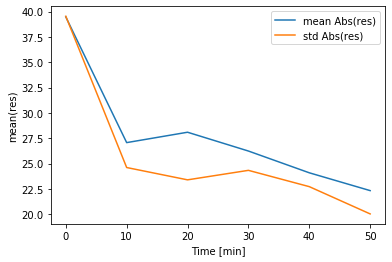

In [1076]:
plt.plot(np.arange(0,60,10),[intraMinList[i].mean()/(392-np.arange(0,60,10)[i]) for i in range(len(intraMinList))])
plt.plot(np.arange(0,60,10),[intraMinList[i].std()/(392-np.arange(0,60,10)[i]) for i in range(len(intraMinList))])
plt.legend(["mean Abs(res)","std Abs(res)"])
plt.xlabel("Time [min]")
plt.ylabel("mean(res)")

### Monthly Data

Text(0, 0.5, 'sum(res)')

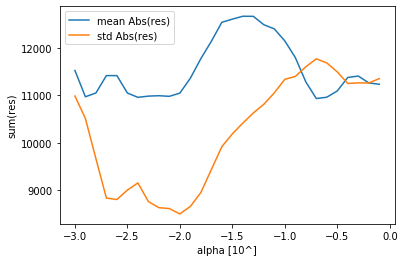

In [1057]:
plt.plot(np.arange(-3,0,0.1),[resSumList20[i].mean() for i in range(len(resSumList20))],label="mean alpha")
plt.plot(np.arange(-3,0,0.1),[resSumList20[i].std() for i in range(len(resSumList20))])
plt.legend(["mean Abs(res)","std Abs(res)"])
plt.xlabel("alpha [10^]")
plt.ylabel("sum(res)")

Text(0, 0.5, 'mean(res)')

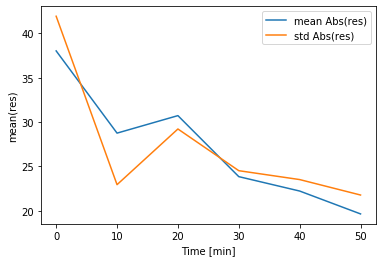

In [1078]:
plt.plot(np.arange(0,60,10),[intraMinList[i].mean()/(392-np.arange(0,60,10)[i]) for i in range(len(intraMinList))])
plt.plot(np.arange(0,60,10),[intraMinList[i].std()/(392-np.arange(0,60,10)[i]) for i in range(len(intraMinList))])
plt.legend(["mean Abs(res)","std Abs(res)"])
plt.xlabel("Time [min]")
plt.ylabel("mean(res)")

### Get rid of the noise
In the section I would to compare the results from previously obtained weekly data by averaging the training data every 10 min. The functions below are the same as getLassoTrain/ValidDF.. just with one more resample options.

In [35]:
def getLassoTrainDFAv(data, avg, nrTrain, stockname, alph):
    traindata=getReturnTrain(data, nrTrain, stockname)
    Xtrain = traindata[0]
    #Yvalid = pd.DataFrame()
    Ytrain=traindata[1]
    fitfct = getLassoFit(data.resample(str(avg)+"T").mean().fillna(method="ffill"), int(nrTrain/avg), stockname, alph)
    Ytrain["Basket"] = fitfct.predict(Xtrain)
    Ytrain["vsBasket"] = Ytrain["Data"]-Ytrain["Basket"]
    Ytrain["MSE"] = Ytrain["vsBasket"]**2
    return Ytrain

def getLassoValidDFAv(data, avg, nrTrain, stockname, alph):
    validdata=getReturnValid(data, nrTrain, stockname)
    Xvalid = validdata[0]
    #Yvalid = pd.DataFrame()
    Yvalid=validdata[1]
    fitfct = getLassoFit(data.resample(str(avg)+"T").mean().fillna(method="ffill"), int(nrTrain/avg), stockname, alph)
    Yvalid["Basket"] = fitfct.predict(Xvalid)-fitfct.predict(Xvalid)[0]
    Yvalid["vsBasket"] = Yvalid["Data"]-Yvalid["Basket"]
    Yvalid["MSE"] = Yvalid["vsBasket"]**2
    return Yvalid

Below, let us look at the difference between different averaging durations:

In [48]:
nr=5
offset=22
#t10=getLassoTrainDFAv(weekData[0+offset*392:(nr+1)*392+offset*392], 10, nr*392+30, "HON US Equity-Open",0.1)
#t0=getLassoTrainDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+30, "HON US Equity-Open",0.1)

v30=getLassoValidDFAv(weekData[0+offset*392:(nr+1)*392+offset*392], 30, nr*392+10, "HON US Equity-Open",0.1)
v10=getLassoValidDFAv(weekData[0+offset*392:(nr+1)*392+offset*392], 10, nr*392+10, "HON US Equity-Open",0.1)
v5=getLassoValidDFAv(weekData[0+offset*392:(nr+1)*392+offset*392], 5, nr*392+10, "HON US Equity-Open",0.1)
v0=getLassoValidDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+10, "HON US Equity-Open",0.1)

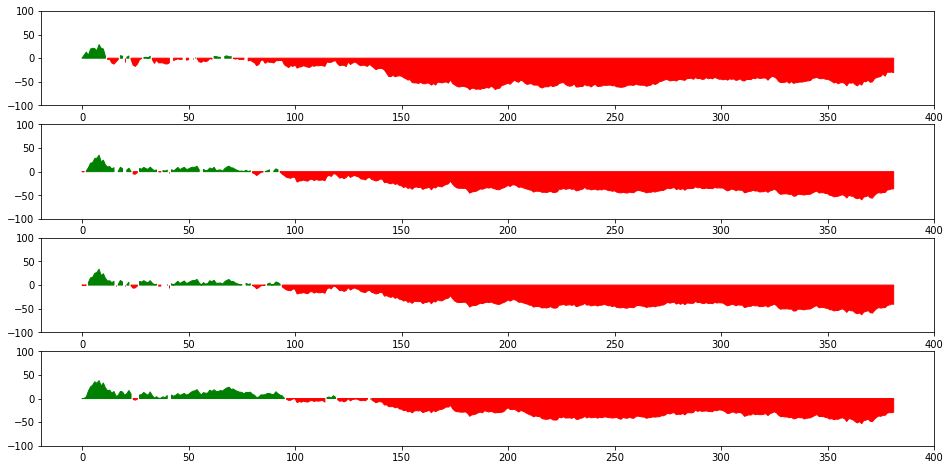

In [49]:
vlist=[v0,v5,v10,v30]
fig, ax = plt.subplots(nrows=4, figsize=(16,8))
for i in range(4):
    x=range(len(vlist[i]["vsBasket"]))
    y=vlist[i]["vsBasket"]
    ax[i].fill_between(x,y, where=y>=0,color="g")
    ax[i].fill_between(x,y, where=y<=0,color="r")
    ax[i].set_ylim([-100,100])
#v0.plot(y=["Data","Basket"],ax=ax[1])

The first impression is good. By averaging, we do have an effect.

In [54]:
nr=5
avgList=[]
for avg in [1,2,5,10,30,60]:
#lassoTrain=getLassoTrainDF(weekData[0+offset*392:(nr+1)*392+offset*392], nr*392+30, "HON US Equity-Open",alpha)
    avgres=[getLassoValidDFAv(weekData[0+offset*392:(nr+1)*392+offset*392], avg, nr*392+10, "HON US Equity-Open",10**(-2.1))["MSE"].mean() for offset in range(62)]
    avgList.append(np.abs(avgres))

Below, it shows the MSE of the model on the predicted data as a function of averaging time for the training data. here I kept the $\alpha$ around $0.01$. For the overall predicting error, there are not much difference.

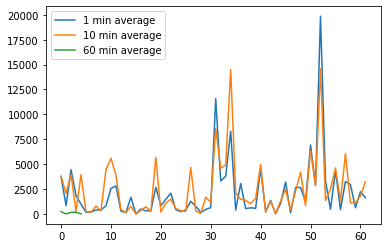

In [61]:
plt.plot(avgList[0], label="1 min average")
plt.plot(avgList[3],label="10 min average")
# Some data points for 60 min average are too large
plt.plot(([j for j in avgList[5] if j<1*10*27]),label="60 min average")
plt.legend()

Interestingly, MSE of the prediction seems to be lowest for much higher data rate. But interestingly the standard deviation of the MSE is the smallest at 10 min average.

Text(0, 0.5, 'MSE')

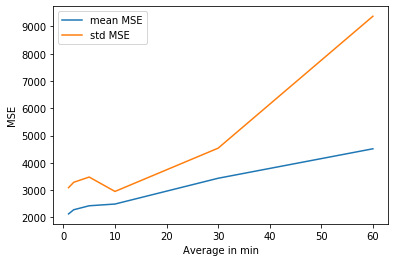

In [62]:
plt.plot([1,2,5,10,30,60],[np.mean([i for i in avgList[i] if i<10**(20)]) for i in range(len(avgList))])
plt.plot([1,2,5,10,30,60],[np.std([i for i in avgList[i] if i<10**(20)]) for i in range(len(avgList))])
plt.legend(["mean MSE","std MSE"])
plt.xlabel("Average in min")
plt.ylabel("MSE")

# Validating Lasso

From here on, I will validate the lasso model by testing it systematically on history data. To determine the accuracy of the model, I use the vsBasket data of the prediction. For every single day, I extract the Mean and Max-Min of that. The idea is that a good prediction, if the market behaves accordingly. The mean of vsBaskt should be around 0 and the Max-Min should be minimal.

The utcome of these can then be used for the flag signal or determining the model accuracy.

I need a function to describe the histogram and the extract the distribution.

In [41]:
# this is a Gaussian to described the distribution later
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# A function which integrates the area below a curve
def nIntegrate(x,y,low,high):
    if low >=min(x):
        lowInd = np.where(x <=low)[0][-1]
    else:
        lowInd = 0
    if high <=max(x):
        if high<=min(x):
            highInd = 0
        else:
            highInd = np.where(x <=high)[0][-1]
    else:
        highInd = len(x)
    return np.sum(y[lowInd:highInd])*np.mean(np.diff(x[lowInd:highInd]))

# Get the mean of a distribution and get the pct of finding a data point within a range.
def getHistParams(data,strg):
    y, x = np.histogram(data, normed=True, bins=int(len(data))); # I bin 4 values.
    x=x[:-1]+np.mean(np.diff(x))/2
    y=y
    n = len(x)                          #the number of data
    #mean = sum(x*y)/n                   #note this correction
    #sigma = (max(x)-min(x))/2       #note this correction
    #popt,pcov = curve_fit(gaus,x,y,p0=[max(y),mean,sigma]);
    mean = np.average(x, weights=y)
    if strg == "Mean":
        prob1 = nIntegrate(x,y,-25,25)
        prob2 = nIntegrate(x,y,-50,50)
        prob3 = nIntegrate(x,y,-100,100)
    elif strg== "MaxMin":
        prob1 = nIntegrate(x,y,0,100)
        prob2 = nIntegrate(x,y,0,150)
        prob3 = nIntegrate(x,y,0,200)
    return [mean, round(100*prob1,1), round(100*prob2,1), round(100*prob3,1)]

# Plot histogram with boundary lines.
def getHistParamPlot(data, strg):
    y, x = np.histogram(data, normed=True, bins=int(len(data))) # I bin 4 values.
    x=x[:-1]+np.mean(np.diff(x))/2
    y=y
    n = len(x)                          #the number of data
    mean = sum(x*y)/n                   #note this correction
    sigma = 50        #note this correction
    popt,pcov = curve_fit(gaus,x,y,p0=[max(y),mean,sigma])
    #plt.plot(x,y,'b+:',label='data')
    
    plt.hist(data, normed=True, bins=int(len(data)/4))
    if strg == "Mean":
        xplt=range(-100,100,1)
        plt.plot(xplt,gaus(xplt,*popt),'r',label='fit')
        plt.axvline(x=-25,color="b")
        plt.axvline(x=25,color="b")
        plt.axvline(x=-50,color="g")
        plt.axvline(x=50,color="g")
        plt.axvline(x=-100,color="y")
        plt.axvline(x=100,color="y")
        plt.xlabel('vsBasket - mean')
    elif strg=="MaxMin":
        xplt=range(0,250,1)
        plt.plot(xplt,gaus(xplt,*popt),'r',label='fit')
        plt.axvline(x=100,color="b")
        plt.axvline(x=150,color="g")
        plt.axvline(x=200,color="y")
        plt.xlabel('vsBasket - MaxMin')
    plt.legend()
    plt.ylabel('Probability [%]')

    
    
# This is warning condition --> the idea is illustrated in onenote.
def getWarningParams(summarydf,ylow,yhigh):
    tempDF =pd.DataFrame(data= {"mean" : abs(summarydf["vsBasket-Mean"]).values, "maxmin" : summarydf["vsBasket-MaxMin"].values})
    tempDF=tempDF.sort_values(by=["maxmin"], ascending=False)
    tempDF=tempDF[(ylow<=tempDF["maxmin"])&(tempDF["maxmin"]<=yhigh)]
    #EMPvsBasketDF
    mean0 = sm.add_constant(tempDF["mean"])
    model = sm.OLS(tempDF["maxmin"], mean0)
    results = model.fit()
    #fit = results.predict(mean0)
    d = results.params[0]
    k = results.params[1]
    s = results.resid.std()
    return [(2*s+d)/(2-k), k, d, s]


def plotCorr(summarydf,ylow,yhigh):
    tempDF =pd.DataFrame(data= {"mean" : abs(summarydf["vsBasket-Mean"]).values, "maxmin" : summarydf["vsBasket-MaxMin"].values})
    tempDF=tempDF.sort_values(by=["maxmin"], ascending=False)
    tempDF=tempDF[(ylow<=tempDF["maxmin"])&(tempDF["maxmin"]<=yhigh)]
    #EMPvsBasketDF
    mean0 = sm.add_constant(tempDF["mean"])
    model = sm.OLS(tempDF["maxmin"], mean0)
    results = model.fit()
    fit = results.predict(mean0)
    
    fig, ax = plt.subplots(ncols=2,  figsize=(16,4))
    ax[0].scatter(tempDF["mean"],tempDF["maxmin"])
    ax[0].plot(tempDF["mean"],fit,color="r")
    ax[1].hist(results.resid, bins=40)
    
    
    
#------------------------------------------------------------------------------    


def getLasseDF(rawdata, compName, averageModel, trainDays, validminut, lassoAlpha, offtestDayStart,offtestDayEnd):
    lassoValidDFlist=[]
    for off in range(offtestDayStart,offtestDayEnd):
        sgllassoDF=getLassoValidDFAv(rawdata[0+off*392:(trainDays+1)*392+off*392], averageModel, trainDays*392+validminut, compName,lassoAlpha)
        lassoValidDFlist.append(sgllassoDF)
    return lassoValidDFlist
    
def getSummaryDF(lassoDFlist, compName, averageModel, trainDays, validminut, lassoAlpha, offtestDayStart,offtestDayEnd):
    lassoMSElist=[]
    lassoVsBasketMeanlist=[]
    lassoVsBasketMaxMinlist=[]
    for off in range(offtestDayEnd-offtestDayStart):
        lassoMSElist.append(np.sqrt(lassoDFlist[off]["MSE"].mean()))
        lassoVsBasketMeanlist.append(lassoDFlist[off]["vsBasket"].mean())
        lassoVsBasketMaxMinlist.append(lassoDFlist[off]["vsBasket"].max()-lassoDFlist[off]["vsBasket"].min())
    resultDF=pd.DataFrame()
    resultDF["sqrtMSE"]=lassoMSElist
    resultDF["vsBasket-Mean"]=lassoVsBasketMeanlist
    resultDF["vsBasket-MaxMin"]=lassoVsBasketMaxMinlist
    return resultDF

def plotLassoDF(rawlassoDF):
    fig, ax = plt.subplots(nrows=3, figsize=(16,8))
    ax[0].plot(rawlassoDF["sqrtMSE"])
    ax[0].legend(["mean MSE"])
    ax[0].set_ylim(0,300)
    ax[0].plot((0, len(rawlassoDF)), (100, 100), '-.', color ="r")

    ax[1].plot(rawlassoDF["vsBasket-Mean"])
    ax[1].legend(["vsBasket-Mean"])
    ax[1].set_ylim(-100,100)
    ax[1].plot((0, len(rawlassoDF)), (50, 50), '-.', color ="r")
    ax[1].plot((0, len(rawlassoDF)), (-50,-50), '-.', color ="r")

    ax[2].plot(rawlassoDF["vsBasket-MaxMin"])
    ax[2].legend(["Min-Max"])
    ax[2].set_ylim(0,400)
    ax[2].plot((0, len(rawlassoDF)), (150, 150), '-.', color ="r")


In [43]:
MSFTLassoDF = getLasseDF(weekData, "MSFT US Equity-Open", 10, 5, 60, 10**(-3),1, 40)
MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MSFT US Equity-Open", 10, 5, 60, 10**(-3),1, 40)

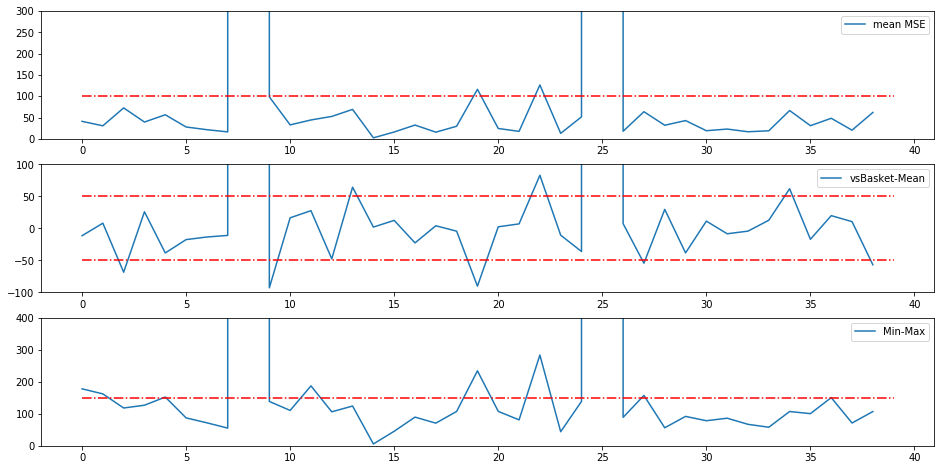

In [44]:
plotLassoDF(MSFTSummaryDF)

In [54]:
#getHistParamPlot([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <10**9], "MaxMin")
print(getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <10**9], "MaxMin"))
print(getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i <10**9], "Mean"))


[107.81676488020642, 47.4, 78.9, 94.7]
[-6.32967144554765, 57.9, 81.6, 100.0]


## Liquid Equity 1: MSFT US

Now we have the fundamentals, let us start analysing the content.<br>
We have the following parameters:
    1. averageing time: 10 min
    2. 5 days of traings data
    3. 1 day of validation ("Prediciton")
    4. Numer of min of the validation day to be included in the training: 60 min
    5. LassoAlpha

### 1. Lasso$\alpha$
we keep all the rest constant.

In [61]:
reslist=[]
scanlist = np.arange(-3,0,0.2)
for alphpower in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MSFT US Equity-Open", 1, 5, 60, 10**(float(alphpower)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MSFT US Equity-Open", 1, 5, 60, 10**(float(alphpower)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150","MaxMin<200"])
alphaDF.index=scanlist

In [2804]:
alphaDF

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150,MaxMin<200
-3.0,-6.329671,57.9,81.6,100.0,107.816765,47.4,78.9,94.7
-2.8,-8.775412,60.5,81.6,100.0,98.706668,47.4,86.8,97.4
-2.6,-4.494524,55.3,84.2,100.0,89.353438,65.8,92.1,94.7
-2.4,-4.833528,55.3,92.1,100.0,80.042005,73.7,100.0,100.0
-2.2,-2.342191,67.5,87.5,100.0,75.749993,82.5,100.0,100.0
-2.0,-1.332389,70.0,95.0,100.0,72.514417,82.5,97.5,100.0
-1.8,0.246406,75.0,95.0,100.0,72.169015,80.0,97.5,100.0
-1.6,-3.473132,70.0,92.5,100.0,75.095355,80.0,97.5,100.0
-1.4,-4.825117,77.5,92.5,100.0,75.937433,80.0,97.5,97.5
-1.2,-4.053900,70.0,95.0,100.0,75.134039,75.0,95.0,100.0


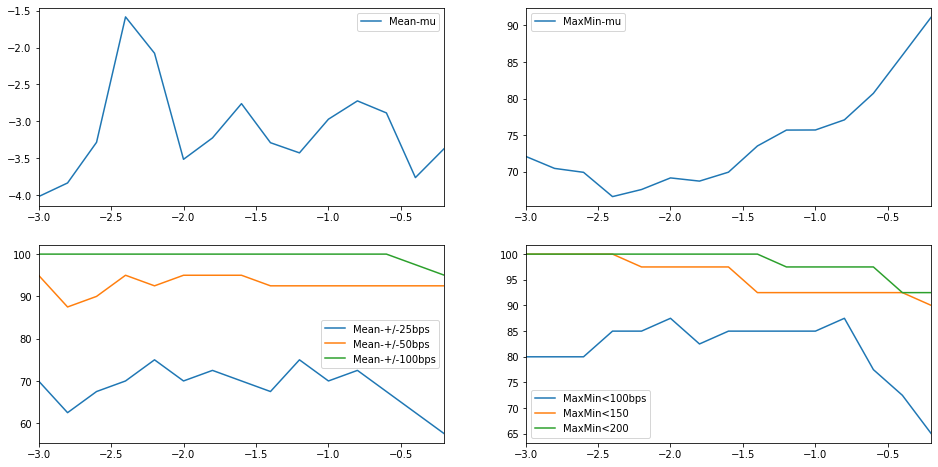

In [62]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150","MaxMin<200"],ax=ax[1,1])

### 2. Minutes of inclusion
Now let us fix the alpha to 0.01 and scan the min to be included.

In [2830]:
reslist=[]
scanlist = np.arange(0,60,5)
for minInc in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MSFT US Equity-Open", 10, 5, minInc, 10**(float(-2)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MSFT US Equity-Open", 10, 5, minInc, 10**(float(-2)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2831]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
0,15.407093,27.5,42.5,77.5,126.586977,20.0,75.0,87.5
5,7.356797,45.0,65.0,92.5,100.401647,52.5,87.5,95.0
10,11.104931,47.5,80.0,90.0,93.902428,57.5,90.0,97.5
15,8.767644,42.5,75.0,95.0,89.937204,60.0,90.0,100.0
20,1.218965,62.5,85.0,97.5,86.005041,70.0,92.5,100.0


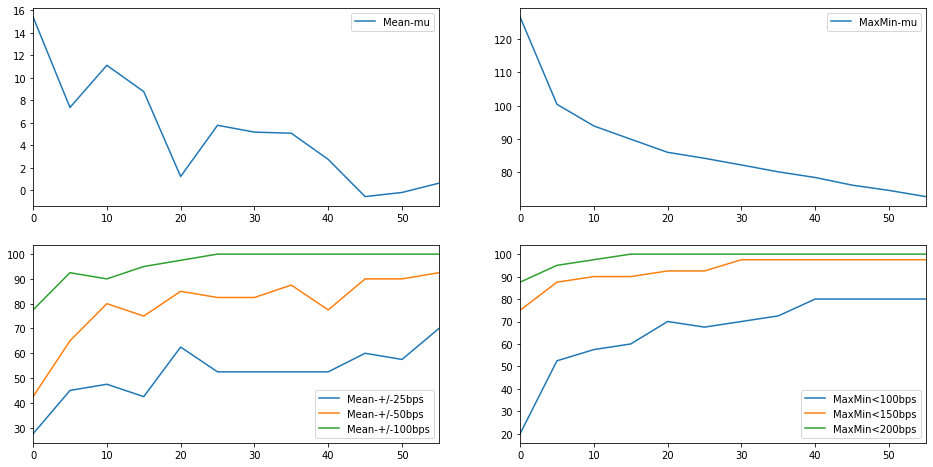

In [2833]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 3. Days of training data

In [2834]:
reslist=[]
scanlist = np.arange(1,20,1)
for nrday in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MSFT US Equity-Open", 10, nrday, 60, 10**(float(-2)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MSFT US Equity-Open", 10, nrday,60, 10**(float(-2)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2835]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,-7.850565e+12,NaN,NaN,NaN,84.323859,66.7,94.4,100.0
2,-7.131759e+10,NaN,NaN,NaN,80.418068,76.9,94.9,97.4
3,-4.942891e+00,62.5,82.5,97.5,83.783543,77.5,95.0,95.0
4,-3.802383e+00,57.5,82.5,97.5,88.941912,62.5,92.5,97.5
5,-1.332389e+00,70.0,95.0,100.0,72.514417,82.5,97.5,100.0


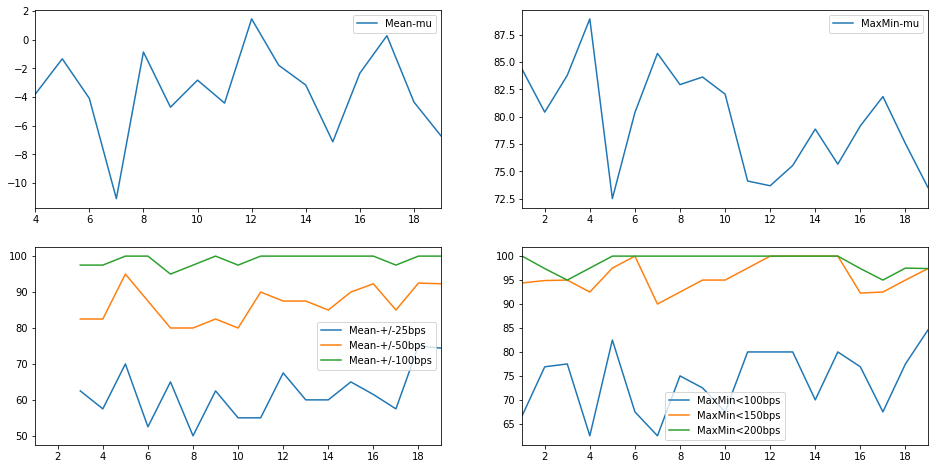

In [2837]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF[3::].plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 4. Average time

In [55]:
reslist=[]
scanlist = np.arange(1,60,5)
for nrAv in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MSFT US Equity-Open", nrAv, 5, 60, 10**(float(-2)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MSFT US Equity-Open", nrAv, 5,60, 10**(float(-2)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [56]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,-3.516091e+00,70.0,95.0,100.0,69.153736,87.5,97.5,100.0
6,-1.053895e+00,67.5,92.5,100.0,68.851937,80.0,97.5,100.0
11,-4.618231e+00,65.0,85.0,100.0,77.809749,75.0,100.0,100.0
16,-5.388362e+13,NaN,NaN,NaN,84.567177,68.4,97.4,100.0
21,-3.466190e+00,67.5,87.5,100.0,86.794595,60.0,90.0,100.0


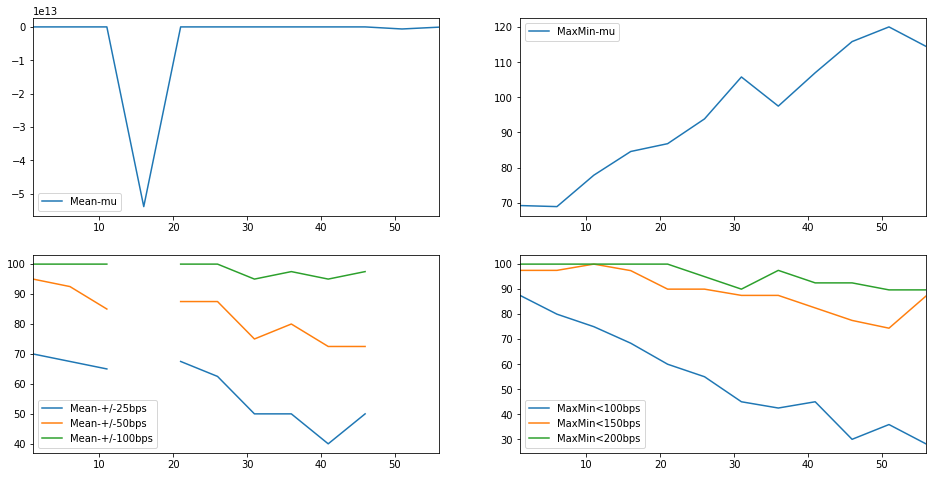

In [57]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 5. Correlations between vsBasket mean and maxmin
Now we set everything to the ideal parameter and look at the vsBasket mean and the amplitude of the swing MaxMin

In [67]:
MSFTLassoDF = getLasseDF(weekData, "MSFT US Equity-Open", 1, 12, 60, 10**(float(-2)), 40)
MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MSFT US Equity-Open", 1, 12,60, 10**(float(-2)), 40)

In [68]:
MSFTSummaryDF.head()

,sqrtMSE,vsBasket-Mean,vsBasket-MaxMin
0,18.916595,6.150689,77.430052
1,14.704955,11.176912,39.914512
2,16.575308,-9.914139,63.052273
3,22.860460,-18.820579,57.510275
4,30.799395,-27.101117,71.721355


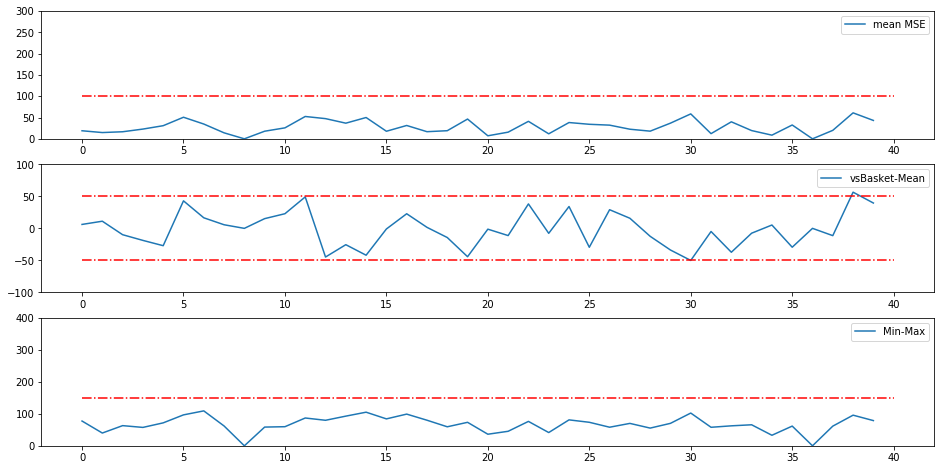

In [69]:
plotLassoDF(MSFTSummaryDF)

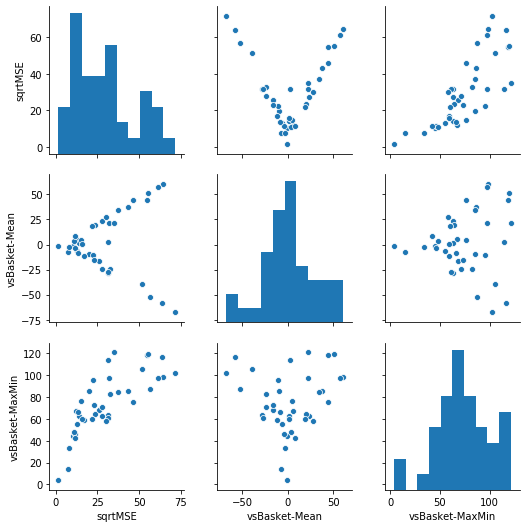

In [2880]:
sns.pairplot(MSFTSummaryDF)

[65.85390272100643, 0.6873537284967799, 54.74395624733007, 15.849461811667396]
[31.388202885855236, 37.5, 65.0, 96.7]


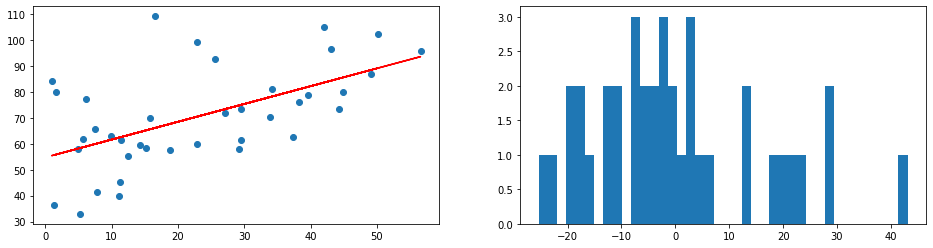

In [72]:
print(getWarningParams(MSFTSummaryDF,20,120))
plotCorr(MSFTSummaryDF,20,120)
print(getHistParams(MSFTSummaryDF,"Mean"))

## Liquid Equity 2: MIDD US

### 1. Lasso$\alpha$
we keep all the rest constant.

In [2889]:
reslist=[]
scanlist = np.arange(-3,0,0.2)
for alphpower in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MIDD US Equity-Open", 10, 5, 60, 10**(float(alphpower)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MIDD US Equity-Open", 10, 5, 60, 10**(float(alphpower)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150","MaxMin<200"])
alphaDF.index=scanlist

In [2890]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150,MaxMin<200
-3.0,-8.934849e+12,NaN,NaN,NaN,161.124289,5.3,44.7,81.6
-2.8,-1.804967e+13,NaN,NaN,NaN,153.165827,10.5,47.4,78.9
-2.6,-2.480649e+13,NaN,NaN,NaN,149.827851,5.1,48.7,89.7
-2.4,-8.652526e+12,NaN,NaN,NaN,142.909298,10.3,53.8,89.7
-2.2,-1.749925e+13,NaN,NaN,NaN,137.024028,17.9,53.8,84.6


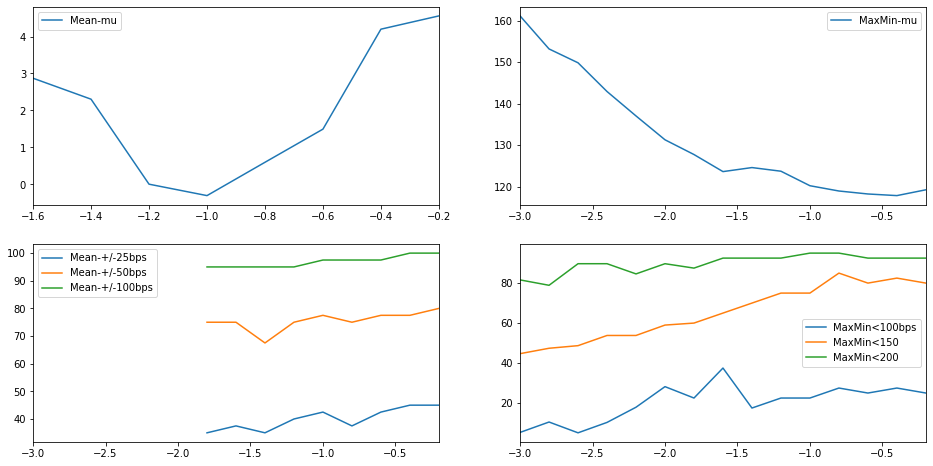

In [2892]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF[-1.7::].plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150","MaxMin<200"],ax=ax[1,1])

### 2. Minutes of inclusion
Now let us fix the alpha to 0.01 and scan the min to be included.

In [2896]:
reslist=[]
scanlist = np.arange(0,60,5)
for minInc in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MIDD US Equity-Open", 10, 5, minInc, 10**(float(-0.4)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MIDD US Equity-Open", 10, 5, minInc, 10**(float(-0.4)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2897]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
0,-18.738906,22.5,42.5,72.5,183.968414,5.0,32.5,62.5
5,0.669514,27.5,55.0,85.0,155.616163,7.5,42.5,85.0
10,2.770964,27.5,57.5,90.0,149.185039,10.0,55.0,80.0
15,5.474535,30.0,62.5,77.5,144.286623,10.0,55.0,82.5
20,7.209364,25.0,52.5,87.5,142.275399,10.0,55.0,82.5


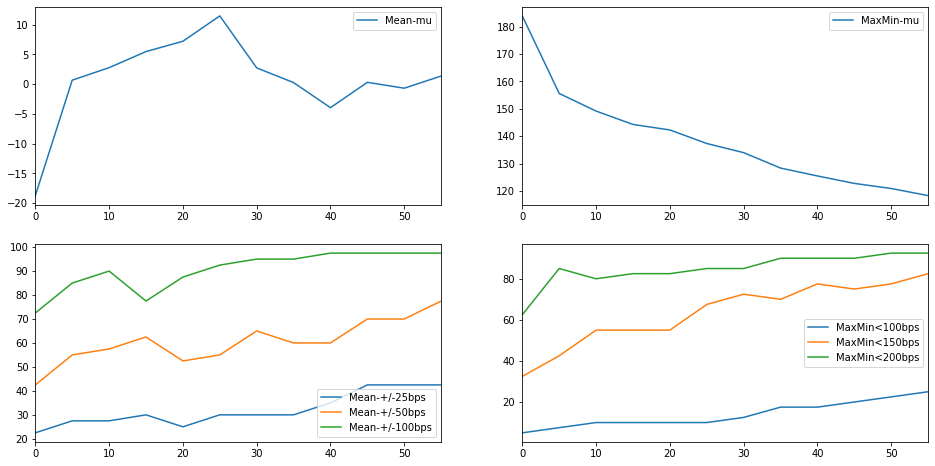

In [2898]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 3. Days of training data

In [2899]:
reslist=[]
scanlist = np.arange(1,20,1)
for nrday in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MIDD US Equity-Open", 10, nrday, 60, 10**(float(-0.4)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MIDD US Equity-Open", 10, nrday,60, 10**(float(-0.4)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2900]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,-7.930499e+13,NaN,NaN,NaN,129.575053,15.4,69.2,92.3
2,1.192487e+01,37.5,70.0,90.0,125.131933,15.0,80.0,87.5
3,-5.259979e-01,42.5,62.5,92.5,129.564372,17.5,67.5,92.5
4,8.749071e-01,42.5,72.5,100.0,114.346672,22.5,77.5,100.0
5,4.198110e+00,45.0,77.5,100.0,117.831997,27.5,82.5,92.5


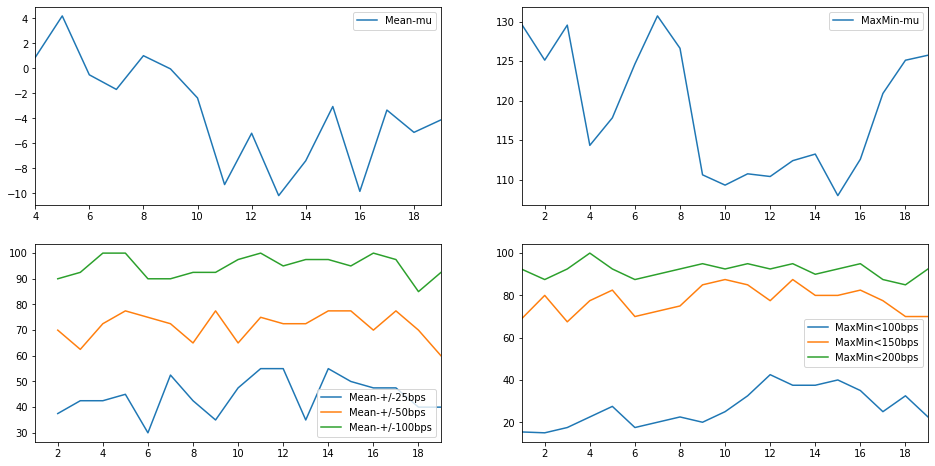

In [2901]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF[3::].plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 4. Average time

In [48]:
reslist=[]
scanlist = np.arange(1,60,5)
for nrAv in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "MIDD US Equity-Open", nrAv, 13, 60, 10**(float(-.4)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "MIDD US Equity-Open", nrAv, 13,60, 10**(float(-0.4)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [49]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,-11.299123,45.0,80.0,95.0,108.751321,42.5,80.0,95.0
6,-9.934221,40.0,72.5,97.5,111.611853,35.0,80.0,95.0
11,-9.182990,37.5,72.5,97.5,108.783487,35.0,82.5,95.0
16,-5.632111,45.0,72.5,100.0,109.430046,35.0,82.5,95.0
21,-6.500653,47.5,75.0,97.5,113.600545,32.5,80.0,92.5


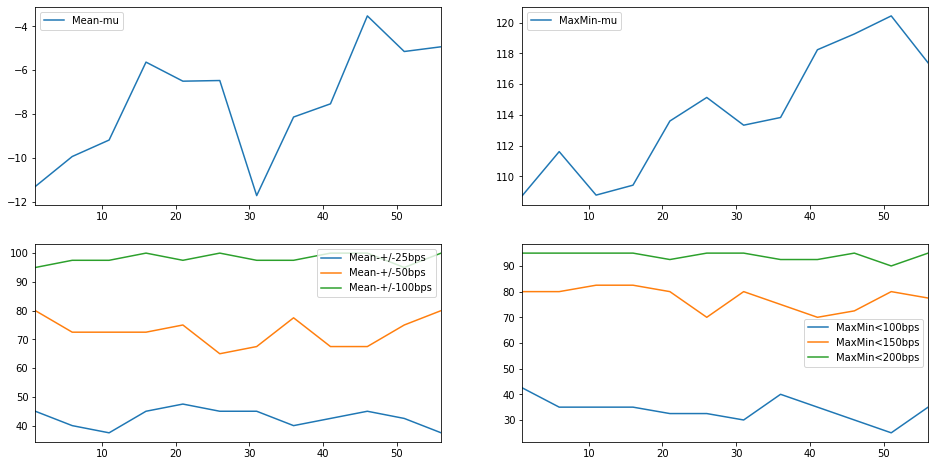

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 5. Correlations between vsBasket mean and maxmin
Now we set everything to the ideal parameter and look at the vsBasket mean and the amplitude of the swing MaxMin

In [3081]:
MIDDLassoDF = getLasseDF(weekData, "MIDD US Equity-Open", 10, 13, 60, 10**(float(-0.4)), 40)
MIDDSummaryDF = getSummaryDF(MIDDLassoDF, "MIDD US Equity-Open", 10, 13,60, 10**(float(-0.4)), 40)

In [2917]:
MIDDSummaryDF.head()

,sqrtMSE,vsBasket-Mean,vsBasket-MaxMin
0,31.525739,-15.758333,149.973617
1,26.950319,15.696994,95.407567
2,50.489181,-47.811491,91.931629
3,65.824109,-58.873586,143.924730
4,93.536966,90.667881,128.242972


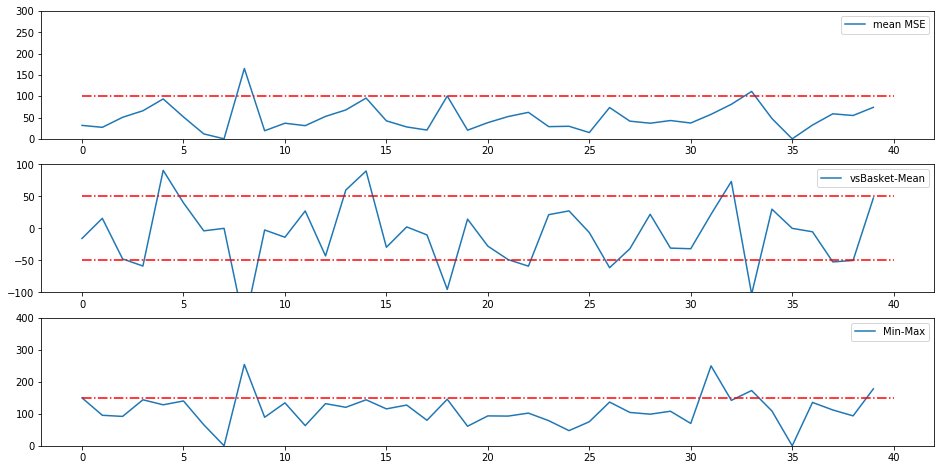

In [2918]:
plotLassoDF(MIDDSummaryDF)

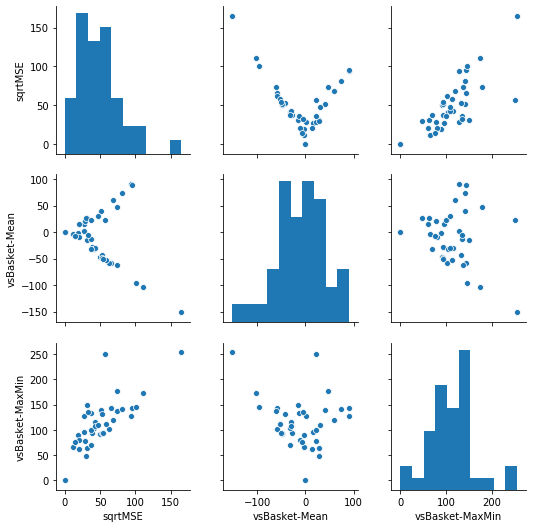

In [2919]:
sns.pairplot(MIDDSummaryDF)

[102.24897417402866, 0.6262509314989165, 86.3105995905198, 27.07691671812172]


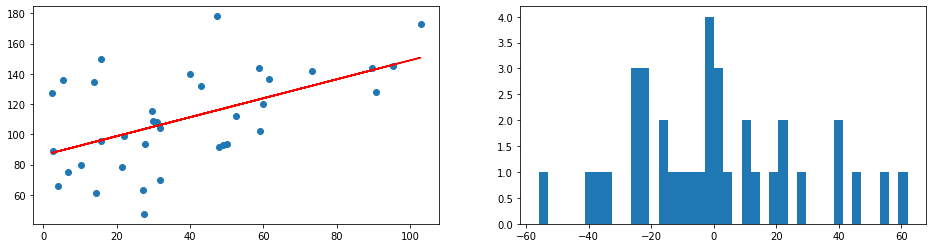

In [3083]:
print(getWarningParams(MIDDSummaryDF,10,240))
plotCorr(MIDDSummaryDF,10,240)

================================================================================

## Iliquid Equity 3: HON US

### 1. Lasso$\alpha$
we keep all the rest constant.

In [2846]:
reslist=[]
scanlist = np.arange(-3,0,0.2)
for alphpower in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "HON US Equity-Open", 10, 5, 60, 10**(float(alphpower)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "HON US Equity-Open", 10, 5, 60, 10**(float(alphpower)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150","MaxMin<200"])
alphaDF.index=scanlist

In [2847]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150,MaxMin<200
-3.0,-3.754257e+11,NaN,NaN,NaN,89.572412,56.4,97.4,100.0
-2.8,-3.777366e+11,NaN,NaN,NaN,81.054785,74.4,100.0,100.0
-2.6,-4.185425e+00,67.5,87.5,100.0,72.994820,77.5,100.0,100.0
-2.4,-2.650194e+00,75.0,90.0,100.0,67.986164,85.0,100.0,100.0
-2.2,-4.061079e+00,72.5,90.0,100.0,67.830679,87.5,100.0,100.0


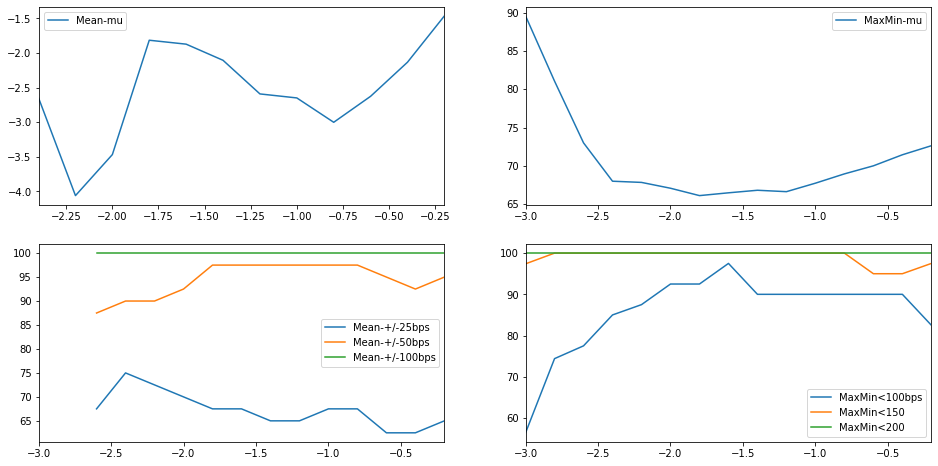

In [2851]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF[-2.4::].plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150","MaxMin<200"],ax=ax[1,1])

### 2. Minutes of inclusion
Now let us fix the alpha to 0.01 and scan the min to be included.

In [2852]:
reslist=[]
scanlist = np.arange(0,60,5)
for minInc in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "HON US Equity-Open", 10, 5, minInc, 10**(float(-1.6)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "HON US Equity-Open", 10, 5, minInc, 10**(float(-1.6)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2854]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
0,-2.251717,37.5,67.5,95.0,102.687341,52.5,85.0,97.5
5,3.245977,47.5,75.0,100.0,86.664706,70.0,95.0,100.0
10,1.012459,52.5,80.0,97.5,82.504083,75.0,95.0,100.0
15,1.486258,57.5,92.5,100.0,77.605571,87.5,97.5,100.0
20,-1.516164,52.5,90.0,100.0,76.086215,87.5,100.0,100.0


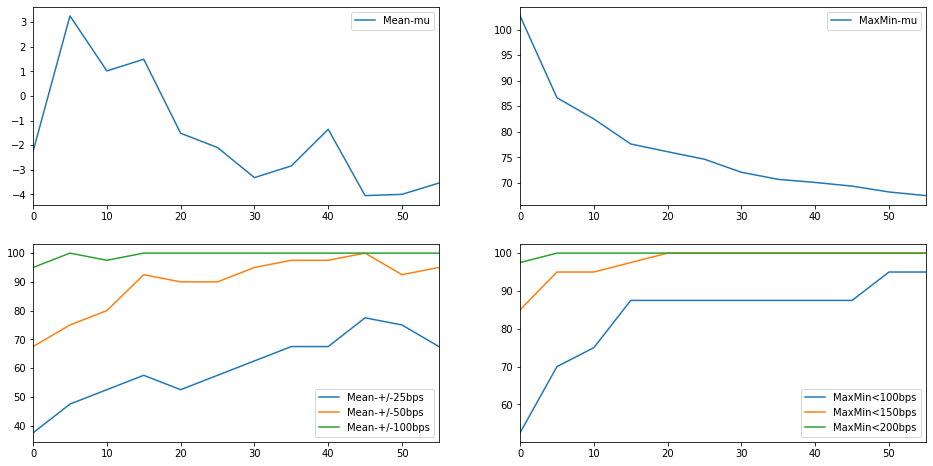

In [2855]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 3. Days of training data

In [2856]:
reslist=[]
scanlist = np.arange(1,20,1)
for nrday in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "HON US Equity-Open", 10, nrday, 60, 10**(float(-1.6)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "HON US Equity-Open", 10, nrday,60, 10**(float(-1.6)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2857]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,-3.140424,52.5,87.5,100.0,79.377133,75.0,100.0,100.0
2,-8.085948,72.5,92.5,100.0,71.448224,87.5,95.0,100.0
3,-2.052401,65.0,95.0,100.0,66.516413,92.5,100.0,100.0
4,-1.460519,66.7,92.3,100.0,71.621933,87.2,97.4,100.0
5,-1.872177,67.5,97.5,100.0,66.471209,97.5,100.0,100.0


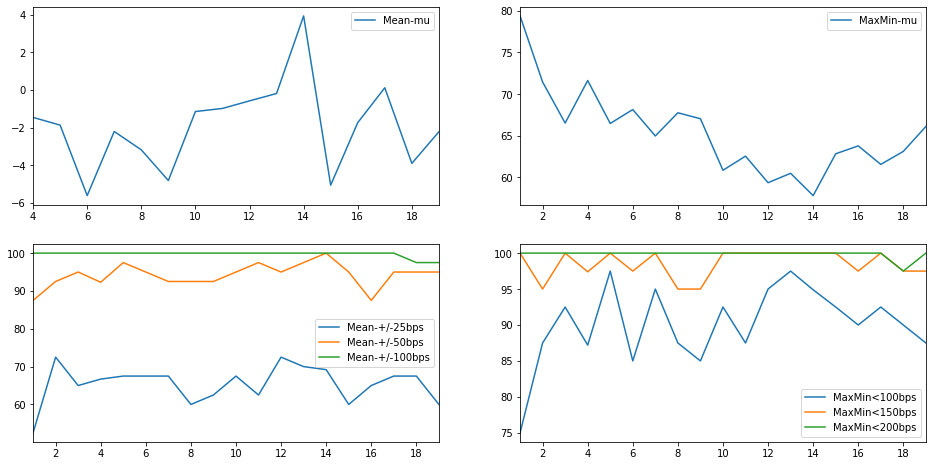

In [2859]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF[3::].plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 4. Average time

In [2860]:
reslist=[]
scanlist = np.arange(1,60,5)
for nrAv in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "HON US Equity-Open", nrAv, 14, 60, 10**(float(-1.6)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "HON US Equity-Open", nrAv, 14,60, 10**(float(-1.6)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2861]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,3.942,69.2,100.0,100.0,57.810103,94.9,100.0,100.0
6,3.942,69.2,100.0,100.0,57.810103,94.9,100.0,100.0
11,3.942,69.2,100.0,100.0,57.810103,94.9,100.0,100.0
16,3.942,69.2,100.0,100.0,57.810103,94.9,100.0,100.0
21,3.942,69.2,100.0,100.0,57.810103,94.9,100.0,100.0


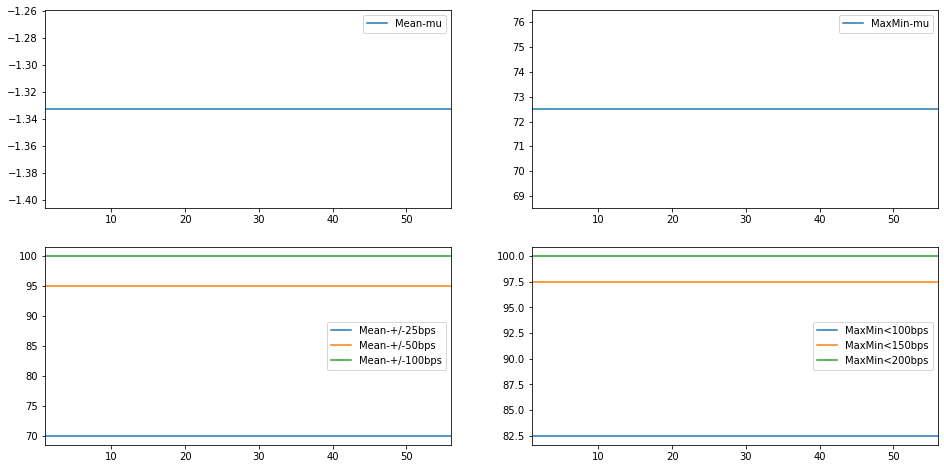

In [2840]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 5. Correlations between vsBasket mean and maxmin
Now we set everything to the ideal parameter and look at the vsBasket mean and the amplitude of the swing MaxMin

In [3077]:
HONLassoDF = getLasseDF(weekData, "HON US Equity-Open", 10, 14, 60, 10**(float(-1.6)), 40)
HONSummaryDF = getSummaryDF(HONLassoDF, "HON US Equity-Open", 10, 14,60, 10**(float(-1.6)), 40)

In [2863]:
HONSummaryDF.head()

,sqrtMSE,vsBasket-Mean,vsBasket-MaxMin
0,23.172160,12.906443,71.248837
1,28.265307,-26.135696,48.829795
2,38.790981,-36.073575,64.149169
3,9.930150,1.797767,46.681048
4,10.647425,-3.770832,65.773133


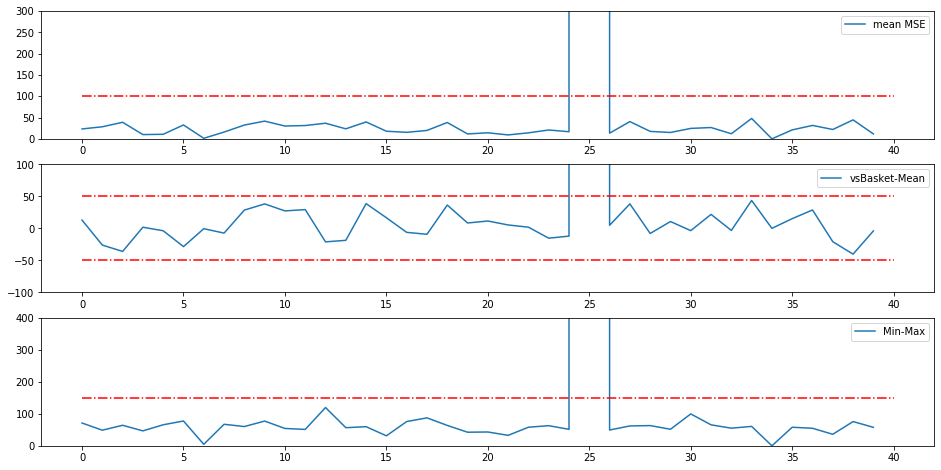

In [3078]:
plotLassoDF(HONSummaryDF)

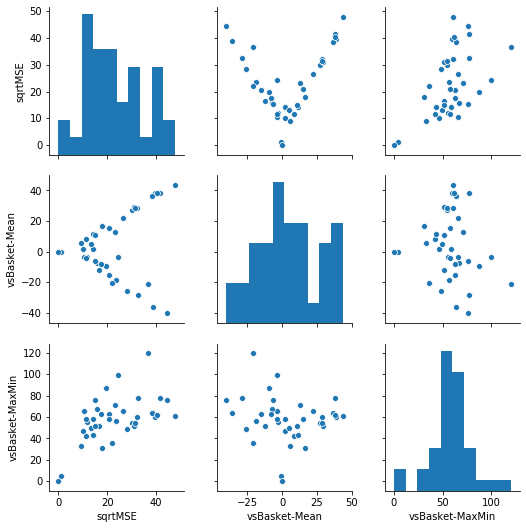

In [2925]:
sns.pairplot(HONSummaryDF.drop([25]))

[50.07411954730576, 0.15107936332904243, 58.27424686382312, 17.154413065159545]


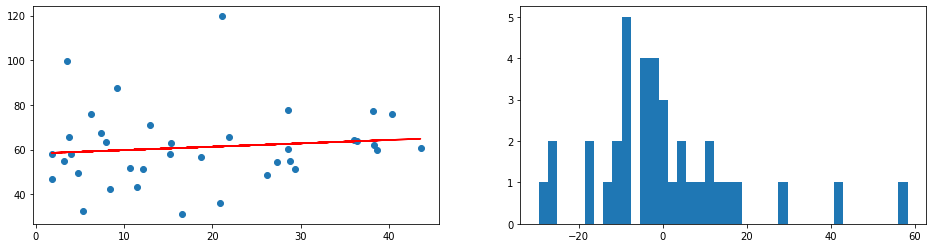

In [3080]:
print(getWarningParams(HONSummaryDF,20,1000))
plotCorr(HONSummaryDF,20,1000)

================================================================================

## Iliquid Equity 4: EMP/A CN

### 1. Lasso$\alpha$
we keep all the rest constant.

In [2932]:
reslist=[]
scanlist = np.arange(-3,0,0.2)
for alphpower in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "EMP/A CN Equity-Open", 10, 5, 60, 10**(float(alphpower)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "EMP/A CN Equity-Open", 10, 5, 60, 10**(float(alphpower)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150","MaxMin<200"])
alphaDF.index=scanlist

In [2933]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150,MaxMin<200
-3.0,13.600262,17.9,51.3,82.1,177.006349,2.6,41.0,64.1
-2.8,17.016954,17.9,46.2,74.4,173.116948,7.7,41.0,69.2
-2.6,20.326294,20.5,48.7,79.5,164.375739,17.9,48.7,66.7
-2.4,20.210132,23.1,46.2,84.6,164.964960,12.8,48.7,64.1
-2.2,12.465675,20.5,51.3,84.6,162.741293,20.5,46.2,74.4


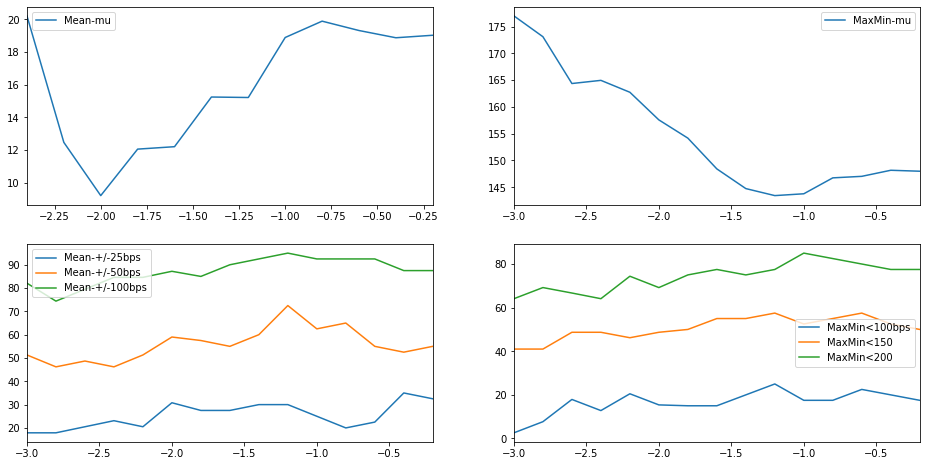

In [2934]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF[-2.4::].plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150","MaxMin<200"],ax=ax[1,1])

### 2. Minutes of inclusion
Now let us fix the alpha to 0.01 and scan the min to be included.

In [2967]:
reslist=[]
scanlist = np.arange(0,60,5)
for minInc in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "EMP/A CN Equity-Open", 10, 5, minInc, 10**(float(-1.5)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "EMP/A CN Equity-Open", 10, 5, minInc, 10**(float(-1.5)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**5], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**5], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2968]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
0,3.980980,10.0,32.5,75.0,217.237678,NaN,20.0,45.0
5,30.776038,5.0,25.0,55.0,199.616008,NaN,30.0,55.0
10,22.493950,5.0,32.5,65.0,185.551399,5.0,32.5,62.5
15,13.262105,17.5,42.5,77.5,179.149899,2.5,37.5,67.5
20,13.162306,17.5,42.5,77.5,173.319634,2.5,42.5,67.5


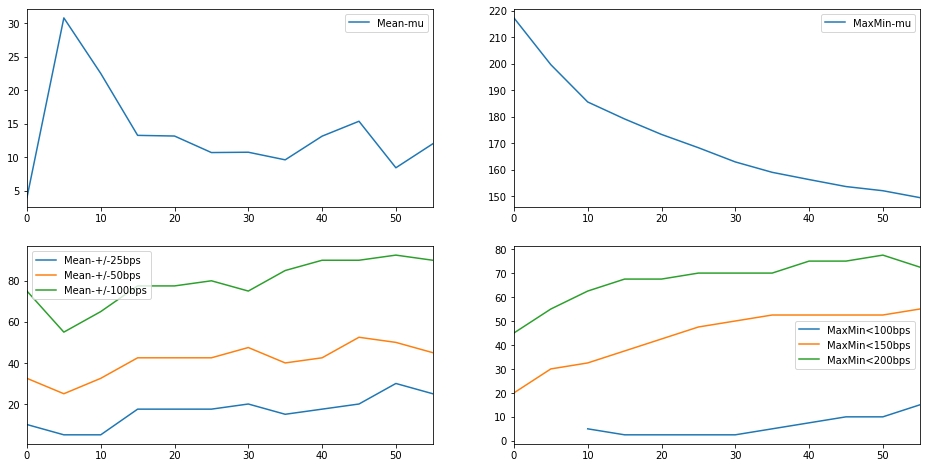

In [2969]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 3. Days of training data

In [2970]:
reslist=[]
scanlist = np.arange(1,20,1)
for nrday in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "EMP/A CN Equity-Open", 10, nrday, 60, 10**(float(-1.5)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "EMP/A CN Equity-Open", 10, nrday,60, 10**(float(-1.5)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2971]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,22.012184,38.5,53.8,87.2,141.568250,15.4,51.3,87.2
2,19.886088,27.5,50.0,82.5,148.651631,12.5,52.5,82.5
3,11.655509,35.0,65.0,100.0,136.551039,25.0,60.0,87.5
4,28.862738,17.5,47.5,80.0,165.614801,17.5,47.5,77.5
5,13.868383,27.5,57.5,92.5,146.819178,17.5,55.0,77.5


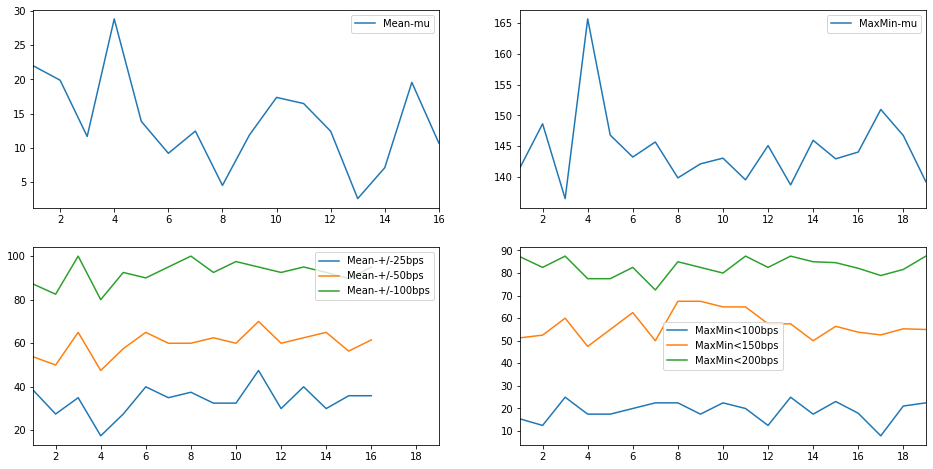

In [2973]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF[:-3].plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 4. Average time

In [2974]:
reslist=[]
scanlist = np.arange(1,60,20)
for nrAv in scanlist:
    MSFTLassoDF = getLasseDF(weekData, "EMP/A CN Equity-Open", nrAv, 13, 60, 10**(float(-1.5)), 40)
    MSFTSummaryDF = getSummaryDF(MSFTLassoDF, "EMP/A CN Equity-Open", nrAv, 13,60, 10**(float(-1.5)), 40)
    reslist.append(
        np.concatenate(
            (getHistParams([i for i in MSFTSummaryDF["vsBasket-Mean"] if i<=10**10], "Mean"), getHistParams([i for i in MSFTSummaryDF["vsBasket-MaxMin"] if i <=10**10], "MaxMin"))))
alphaDF = pd.DataFrame(np.transpose(reslist).transpose(),
                      columns=["Mean-mu", "Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps","MaxMin-mu", "MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"])
alphaDF.index=scanlist

In [2975]:
alphaDF.head()

,Mean-mu,Mean-+/-25bps,Mean-+/-50bps,Mean-+/-100bps,MaxMin-mu,MaxMin<100bps,MaxMin<150bps,MaxMin<200bps
1,2.558069,40.0,62.5,95.0,138.768718,25.0,57.5,87.5
21,2.558069,40.0,62.5,95.0,138.768718,25.0,57.5,87.5
41,2.558069,40.0,62.5,95.0,138.768718,25.0,57.5,87.5


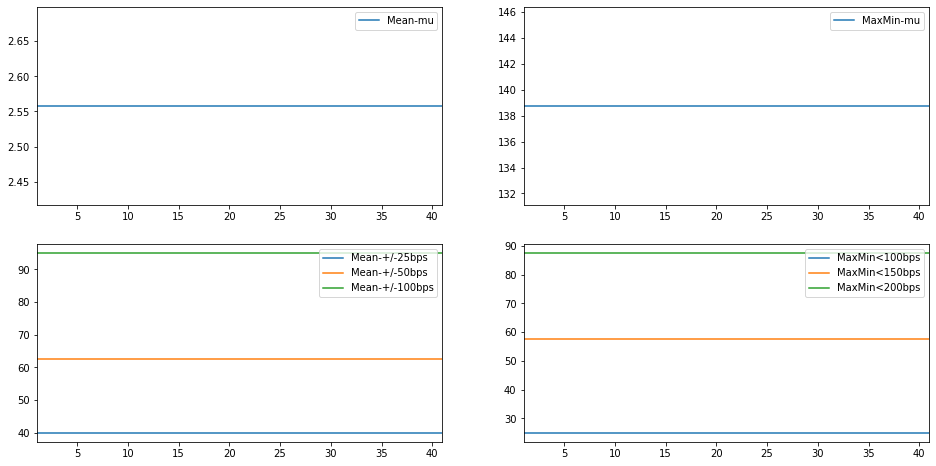

In [2976]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
alphaDF.plot(y=["Mean-mu"],ax=ax[0,0])
alphaDF.plot(y=["MaxMin-mu"],ax=ax[0,1])
alphaDF.plot(y=["Mean-+/-25bps","Mean-+/-50bps","Mean-+/-100bps"],ax=ax[1,0])
alphaDF.plot(y=["MaxMin<100bps","MaxMin<150bps","MaxMin<200bps"],ax=ax[1,1])

### 5. Correlations between vsBasket mean and maxmin
Now we set everything to the ideal parameter and look at the vsBasket mean and the amplitude of the swing MaxMin

In [2977]:
EMPLassoDF = getLasseDF(weekData, "EMP/A CN Equity-Open", 10, 13, 60, 10**(float(-1.5)), 40)
EMPSummaryDF = getSummaryDF(EMPLassoDF, "EMP/A CN Equity-Open", 10, 13,60, 10**(float(-1.5)), 40)

In [2978]:
EMPSummaryDF.head()

,sqrtMSE,vsBasket-Mean,vsBasket-MaxMin
0,54.681416,-34.083057,174.995695
1,29.230090,-17.277317,96.164197
2,18.211427,-7.085971,62.630409
3,90.034746,-83.644461,141.614908
4,31.289949,24.235476,92.866221


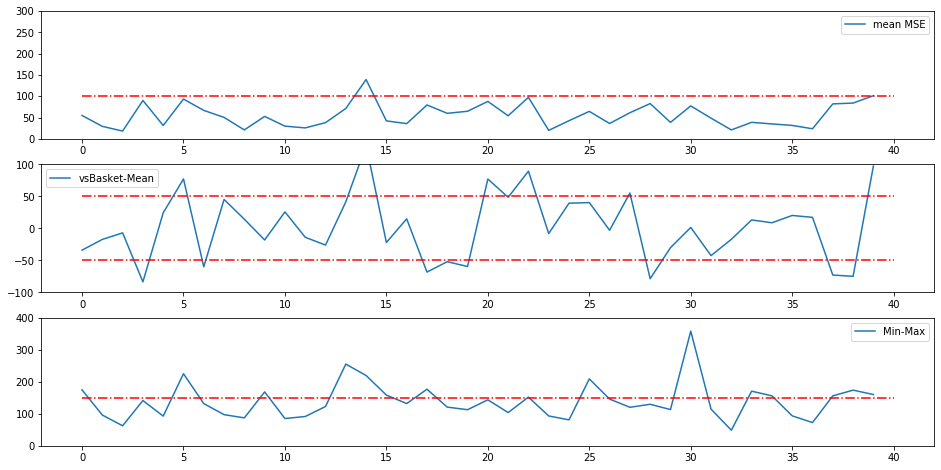

In [2979]:
plotLassoDF(EMPSummaryDF)

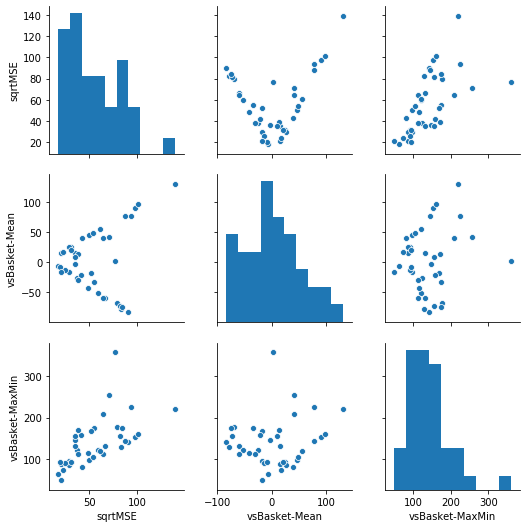

In [2980]:
sns.pairplot(EMPSummaryDF)

Let us now look at the correlation between vsBasket-Mean and vsBasketMaxMin.<br>
In the following the final formular for the error message similiar to the OTAS system. <br>
Let us say, that the mean of vsBasket ($m>0$). I want the lower bound ($lb$) of the predicted vsBasket (95% line) to be always below 0. <br>
So the warning condition is: <br>
$0<m-(lb+\sigma)$<br>
where $lb = \frac{k\,m+off}{2}$, $(off, k)$ are the offset and the slope of the fit and $\sigma$ is the standard devitaion of the residual. (the factor of 2 for the 95% cancels out)

$m>\frac{2\sigma+d}{2-k}$


[145.19588829773323, 0.7358638586728661, 101.72808573902354, 40.90964211511924]


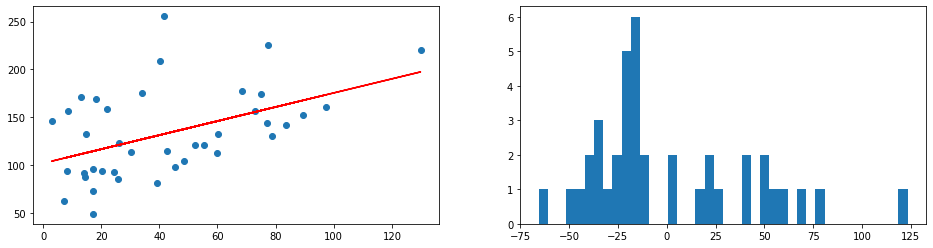

In [3076]:
print(getWarningParams(EMPSummaryDF,10,300))
plotCorr(EMPSummaryDF,10,300)